<a id="id2"></a> <br> 
# 1. Get the Data (Collect / Obtain)

## All imports used in this kernel

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics

from itertools import product

import altair as alt
from altair.vega import v5
from IPython.display import HTML
# alt.renderers.enable('notebook')

In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

## All function used in this kernel

In [3]:
# using ideas from this kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey
def prepare_altair():
    """
    Helper function to prepare altair for working.
    """
    vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v5.SCHEMA_VERSION
    vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
    vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
    vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
    noext = "?noext"
    
    paths = {
        'vega': vega_url + noext,
        'vega-lib': vega_lib_url + noext,
        'vega-lite': vega_lite_url + noext,
        'vega-embed': vega_embed_url + noext
    }
    
    workaround = f"""    requirejs.config({{
        baseUrl: 'https://cdn.jsdelivr.net/npm/',
        paths: {paths}
    }});
    """
    
    return workaround
    

def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
           

@add_autoincrement
def render(chart, id="vega-chart"):
    """
    Helper function to plot altair visualizations.
    """
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )
    

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
    

@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True


def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()
    

def train_model_regression(X, X_test, y, params, folds, model_type='lgb', eval_metric='mae', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error},
                    'group_mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'scoring_function': group_mean_log_mae},
                    'mse': {'lgb_metric_name': 'mse',
                        'catboost_metric_name': 'MSE',
                        'sklearn_scoring_function': metrics.mean_squared_error}
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        if eval_metric != 'group_mae':
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict
    


def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns == None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros((len(X), len(set(y.values))))
    
    # averaged predictions on train data
    prediction = np.zeros((len(X_test), oof.shape[1]))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid
        scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid[:, 1]))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

# setting up altair
workaround = prepare_altair()
HTML("".join((
    "<script>",
    workaround,
    "</script>",
)))

<a id="id3"></a> <br> 
# 2. Load the Dataset

Let's load all necessary datasets

In [4]:
from pathlib import Path

INPUT = Path("./data")
OPEN_BABEL = Path("./data")
CUSTOM = Path("./data")
CSV_TRAIN = INPUT / "train.csv"
CSV_TEST = INPUT / "test.csv"
CSV_SUBMISSION = INPUT / "sample_submission.csv"
CSV_DIPOLE_MOMENTS = INPUT / "dipole_moments.csv"
CSV_MAGNETIC_SHIELDING_TENSORS = INPUT / "magnetic_shielding_tensors.csv"
CSV_MULLIKEN_CHARGES = INPUT / "mulliken_charges.csv"
CSV_POTENTIAL_ENERGY = INPUT / "potential_energy.csv"
CSV_SCALAR_COUPLING_CONTRIBUTIONS = INPUT / "scalar_coupling_contributions.csv"
CSV_STRUCTURES = INPUT / "structures.csv"
CSV_TRAIN_CHARGES = OPEN_BABEL / "train_ob_charges.csv"
CSV_TEST_CHARGES = OPEN_BABEL / "test_ob_charges.csv"
CSV_DAIJ2 = CUSTOM / "daij2.csv"
CSV_NEIBORS_DIST = CUSTOM / "neibors_dist_df.csv"
CSV_DIST_FEATURES = CUSTOM / "dist_features.csv"
CSV_LINK = CUSTOM / "link_info.csv"
CSV_ATOM_INFO = CUSTOM / "dist_atom_info.csv"
CSV_RADIUS_BASED_INFO = CUSTOM / "radius_based_info.csv"

In [5]:
train = pd.read_csv(CSV_TRAIN)
test = pd.read_csv(CSV_TEST)
# sub = pd.read_csv(CSV_SUBMISSION)
# structures = pd.read_csv(CSV_STRUCTURES)
scalar_coupling_contributions = pd.read_csv(CSV_SCALAR_COUPLING_CONTRIBUTIONS)
# train_charges = pd.read_csv(CSV_TRAIN_CHARGES)[["molecule_name","atom_index","eem"]]
# test_charges = pd.read_csv(CSV_TEST_CHARGES)[["molecule_name","atom_index","eem"]]
# daij2 = pd.read_csv(CSV_DAIJ2)
# neighbors_dist = pd.read_csv(CSV_NEIBORS_DIST)
# dist_features = pd.read_csv(CSV_DIST_FEATURES)
# link_info = pd.read_csv(CSV_LINK)
# dist_atom_info = pd.read_csv(CSV_ATOM_INFO)
# radius_based_info = pd.read_csv(CSV_RADIUS_BASED_INFO)

In [6]:
n_estimators_default = 6000

In [7]:
train = pd.merge(train, scalar_coupling_contributions, how = 'left',
                  left_on  = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'],
                  right_on = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

In [8]:
train.head(10)

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   
5   5  dsgdb9nsd_000001             2             3  2JHH   
6   6  dsgdb9nsd_000001             2             4  2JHH   
7   7  dsgdb9nsd_000001             3             0  1JHC   
8   8  dsgdb9nsd_000001             3             4  2JHH   
9   9  dsgdb9nsd_000001             4             0  1JHC   

   scalar_coupling_constant                  fc        sd      pso       dso  
0        84.807599999999994  83.022400000000005  0.254579  1.25862  0.272010  
1       -11.257000000000000 -11.034700000000001  0.352978  2.85839 -3.433600  
2       -11.254799999999999 -11.032500000000001  0.352944  2.85852 -3.433870  
3       -11.254300000000001 -11.031900000000000  0.352934  2.85855 -3.433930  
4        84.807400000000001  83.022199999999998  0.254585  1.25861  0.272013  
5       -11.254099999999999 -11.031700000000001  0.352932  2.85856 -3.433950  
6       -11.254799999999999 -11.032400000000001  0.352943  2.85853 -3.433870  
7        84.809299999999993  83.024100000000004  0.254634  1.25856  0.272012  
8       -11.254300000000001 -11.031900000000000  0.352943  2.85856 -3.433930  
9        84.809500000000000  83.024299999999997  0.254628  1.25856  0.272012

In [9]:
test.head(10)

id     molecule_name  atom_index_0  atom_index_1  type
0  4658147  dsgdb9nsd_000004             2             0  2JHC
1  4658148  dsgdb9nsd_000004             2             1  1JHC
2  4658149  dsgdb9nsd_000004             2             3  3JHH
3  4658150  dsgdb9nsd_000004             3             0  1JHC
4  4658151  dsgdb9nsd_000004             3             1  2JHC
5  4658152  dsgdb9nsd_000015             3             0  1JHC
6  4658153  dsgdb9nsd_000015             3             2  3JHC
7  4658154  dsgdb9nsd_000015             3             4  2JHH
8  4658155  dsgdb9nsd_000015             3             5  2JHH
9  4658156  dsgdb9nsd_000015             4             0  1JHC

In [10]:
scalar_coupling_contributions.head(5)

molecule_name  atom_index_0  atom_index_1  type                  fc  \
0  dsgdb9nsd_000001             1             0  1JHC  83.022400000000005   
1  dsgdb9nsd_000001             1             2  2JHH -11.034700000000001   
2  dsgdb9nsd_000001             1             3  2JHH -11.032500000000001   
3  dsgdb9nsd_000001             1             4  2JHH -11.031900000000000   
4  dsgdb9nsd_000001             2             0  1JHC  83.022199999999998   

         sd      pso       dso  
0  0.254579  1.25862  0.272010  
1  0.352978  2.85839 -3.433600  
2  0.352944  2.85852 -3.433870  
3  0.352934  2.85855 -3.433930  
4  0.254585  1.25861  0.272013

In [11]:
# pd.concat(objs=[train['scalar_coupling_constant'],scalar_coupling_contributions['fc'] ],axis=1)[:10]

In [12]:
del scalar_coupling_contributions
gc.collect()

14

<a id="id4"></a> <br> 
# 3. Data Pre-processing

## Feature generation

In [13]:
structures = pd.read_csv(CSV_STRUCTURES)

In [14]:
from tqdm import tqdm_notebook as tqdm
atomic_radius = {'H':0.38, 'C':0.77, 'N':0.75, 'O':0.73, 'F':0.71} # Without fudge factor

fudge_factor = 0.05
atomic_radius = {k:v + fudge_factor for k,v in atomic_radius.items()}
print(atomic_radius)

electronegativity = {'H':2.2, 'C':2.55, 'N':3.04, 'O':3.44, 'F':3.98}

#structures = pd.read_csv(structures, dtype={'atom_index':np.int8})

atoms = structures['atom'].values
atoms_en = [electronegativity[x] for x in tqdm(atoms)]
atoms_rad = [atomic_radius[x] for x in tqdm(atoms)]

structures['EN'] = atoms_en
structures['rad'] = atoms_rad

display(structures.head())

{'H': 0.43, 'C': 0.8200000000000001, 'N': 0.8, 'O': 0.78, 'F': 0.76}


molecule_name  atom_index atom             x             y  \
0  dsgdb9nsd_000001           0    C -0.0126981359  1.0858041580   
1  dsgdb9nsd_000001           1    H  0.0021504160 -0.0060313176   
2  dsgdb9nsd_000001           2    H  1.0117308430  1.4637511620   
3  dsgdb9nsd_000001           3    H -0.5408150690  1.4475266140   
4  dsgdb9nsd_000001           4    H -0.5238136345  1.4379326440   

              z    EN   rad  
0  0.0080009958  2.55  0.82  
1  0.0019761204  2.20  0.43  
2  0.0002765748  2.20  0.43  
3 -0.8766437152  2.20  0.43  
4  0.9063972942  2.20  0.43

In [15]:
del atoms, atoms_en, atoms_rad
gc.collect()

14

### Chemical Bond Calculation
https://www.kaggle.com/adrianoavelar/bond-calculaltion-lb-0-82

In [16]:
i_atom = structures['atom_index'].values
p = structures[['x', 'y', 'z']].values
p_compare = p
m = structures['molecule_name'].values
m_compare = m
r = structures['rad'].values
r_compare = r

source_row = np.arange(len(structures))
max_atoms = 28

bonds = np.zeros((len(structures)+1, max_atoms+1), dtype=np.int8)
bond_dists = np.zeros((len(structures)+1, max_atoms+1), dtype=np.float32)

print('Calculating bonds')

for i in tqdm(range(max_atoms-1)):
    p_compare = np.roll(p_compare, -1, axis=0)
    m_compare = np.roll(m_compare, -1, axis=0)
    r_compare = np.roll(r_compare, -1, axis=0)
    
    mask = np.where(m == m_compare, 1, 0) #Are we still comparing atoms in the same molecule?
    dists = np.linalg.norm(p - p_compare, axis=1) * mask
    r_bond = r + r_compare
    
    bond = np.where(np.logical_and(dists > 0.0001, dists < r_bond), 1, 0)
    
    source_row = source_row
    target_row = source_row + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_row = np.where(np.logical_or(target_row > len(structures), mask==0), len(structures), target_row) #If invalid target, write to dummy row
    
    source_atom = i_atom
    target_atom = i_atom + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_atom = np.where(np.logical_or(target_atom > max_atoms, mask==0), max_atoms, target_atom) #If invalid target, write to dummy col
    
    bonds[(source_row, target_atom)] = bond
    bonds[(target_row, source_atom)] = bond
    bond_dists[(source_row, target_atom)] = dists
    bond_dists[(target_row, source_atom)] = dists

bonds = np.delete(bonds, axis=0, obj=-1) #Delete dummy row
bonds = np.delete(bonds, axis=1, obj=-1) #Delete dummy col
bond_dists = np.delete(bond_dists, axis=0, obj=-1) #Delete dummy row
bond_dists = np.delete(bond_dists, axis=1, obj=-1) #Delete dummy col

print('Counting and condensing bonds')

bonds_numeric = [[i for i,x in enumerate(row) if x] for row in tqdm(bonds)]
bond_lengths = [[dist for i,dist in enumerate(row) if i in bonds_numeric[j]] for j,row in enumerate(tqdm(bond_dists))]
bond_lengths_mean = [ np.mean(x) for x in bond_lengths]
bond_lengths_median  = [ np.median(x) for x in bond_lengths]
bond_lengths_std = [ np.std(x) for x in bond_lengths]
n_bonds = [len(x) for x in bonds_numeric]

#bond_data = {'bond_' + str(i):col for i, col in enumerate(np.transpose(bonds))}
#bond_data.update({'bonds_numeric':bonds_numeric, 'n_bonds':n_bonds})

bond_data = {'n_bonds':n_bonds, 'bond_lengths_mean': bond_lengths_mean,'bond_lengths_std':bond_lengths_std, 'bond_lengths_median': bond_lengths_median }
bond_df = pd.DataFrame(bond_data)
structures = structures.join(bond_df)
display(structures.head(20))

Calculating bonds



Counting and condensing bonds


molecule_name  atom_index atom             x             y  \
0   dsgdb9nsd_000001           0    C -0.0126981359  1.0858041580   
1   dsgdb9nsd_000001           1    H  0.0021504160 -0.0060313176   
2   dsgdb9nsd_000001           2    H  1.0117308430  1.4637511620   
3   dsgdb9nsd_000001           3    H -0.5408150690  1.4475266140   
4   dsgdb9nsd_000001           4    H -0.5238136345  1.4379326440   
5   dsgdb9nsd_000002           0    N -0.0404260543  1.0241077530   
6   dsgdb9nsd_000002           1    H  0.0172574639  0.0125452063   
7   dsgdb9nsd_000002           2    H  0.9157893661  1.3587451950   
8   dsgdb9nsd_000002           3    H -0.5202777357  1.3435321260   
9   dsgdb9nsd_000003           0    O -0.0343604951  0.9775395708   
10  dsgdb9nsd_000003           1    H  0.0647664923  0.0205721989   
11  dsgdb9nsd_000003           2    H  0.8717903737  1.3007924050   
12  dsgdb9nsd_000004           0    C  0.5995394918  0.0000000000   
13  dsgdb9nsd_000004           1    C -0.5995394918  0.0000000000   
14  dsgdb9nsd_000004           2    H -1.6616385860  0.0000000000   
15  dsgdb9nsd_000004           3    H  1.6616385860  0.0000000000   
16  dsgdb9nsd_000005           0    C -0.0133239314  1.1324657150   
17  dsgdb9nsd_000005           1    N  0.0023107217 -0.0191585871   
18  dsgdb9nsd_000005           2    H -0.0278026991  2.1989492960   
19  dsgdb9nsd_000007           0    C -0.0187040036  1.5255820150   

               z    EN   rad  n_bonds  bond_lengths_mean   bond_lengths_std  \
0   0.0080009958  2.55  0.82        4  1.091949701309204  0.000002762467830   
1   0.0019761204  2.20  0.43        1  1.091953039169312  0.000000000000000   
2   0.0002765748  2.20  0.43        1  1.091951608657837  0.000000000000000   
3  -0.8766437152  2.20  0.43        1  1.091946363449097  0.000000000000000   
4   0.9063972942  2.20  0.43        1  1.091947555541992  0.000000000000000   
5   0.0625637998  3.04  0.80        3  1.017194986343384  0.000009144474461   
6  -0.0273771593  2.20  0.43        1  1.017189979553223  0.000000000000000   
7  -0.0287577581  2.20  0.43        1  1.017187237739563  0.000000000000000   
8  -0.7755426124  2.20  0.43        1  1.017207860946655  0.000000000000000   
9   0.0076015923  3.44  0.78        2  0.962106823921204  0.000000000000000   
10  0.0015346341  2.20  0.43        1  0.962106823921204  0.000000000000000   
11  0.0006931336  2.20  0.43        1  0.962106823921204  0.000000000000000   
12  1.0000000000  2.55  0.82        2  1.130589008331299  0.068489968776703   
13  1.0000000000  2.55  0.82        2  1.130589008331299  0.068489968776703   
14  1.0000000000  2.20  0.43        1  1.062099099159241  0.000000000000000   
15  1.0000000000  2.20  0.43        1  1.062099099159241  0.000000000000000   
16  0.0082758861  2.55  0.82        2  1.109173059463501  0.042574942111969   
17  0.0019287305  3.04  0.80        1  1.151747941970825  0.000000000000000   
18  0.0141537903  2.20  0.43        1  1.066598057746887  0.000000000000000   
19  0.0104328082  2.55  0.82        4  1.203627109527588  0.188217103481293   

    bond_lengths_median  
0     1.091949582099915  
1     1.091953039169312  
2     1.091951608657837  
3     1.091946363449097  
4     1.091947555541992  
5     1.017189979553223  
6     1.017189979553223  
7     1.017187237739563  
8     1.017207860946655  
9     0.962106823921204  
10    0.962106823921204  
11    0.962106823921204  
12    1.130589008331299  
13    1.130589008331299  
14    1.062099099159241  
15    1.062099099159241  
16    1.109173059463501  
17    1.151747941970825  
18    1.066598057746887  
19    1.094963073730469

In [17]:
del bond_df, bond_data, n_bonds, bond_lengths_std, bond_lengths_median, bond_lengths_mean
del bond_lengths, bonds_numeric, bond_dists, bonds
gc.collect()

14

### Coulomb, Van der Walls & Yukawa interactions(Giba Kernel Features)
https://www.kaggle.com/titericz/giba-r-data-table-simple-features-1-17-lb

In [18]:
daij2 = pd.read_csv(CSV_DAIJ2)

In [19]:
daij2.head()

molecule_name  atom_index          coulomb_C  coulomb_F  \
0  dsgdb9nsd_000001           0  0.000000000000000        0.0   
1  dsgdb9nsd_000001           1  0.915790281640328        0.0   
2  dsgdb9nsd_000001           2  0.915791490193655        0.0   
3  dsgdb9nsd_000001           3  0.915795884404050        0.0   
4  dsgdb9nsd_000001           4  0.915794909874161        0.0   

          coulomb_H  coulomb_N  coulomb_O           yukawa_C  yukawa_F  \
0  3.66317256611219        0.0        0.0  0.000000000000000       0.0   
1  1.68242414611224        0.0        0.0  0.335560483673896       0.0   
2  1.68242355721263        0.0        0.0  0.335560967227149       0.0   
3  1.68241499685346        0.0        0.0  0.335562725386080       0.0   
4  1.68241502091985        0.0        0.0  0.335562335469493       0.0   

            yukawa_H  yukawa_N  yukawa_O           vander_C  vander_F  \
0  1.342246511756620       0.0       0.0  0.000000000000000       0.0   
1  0.504327699993100       0.0       0.0  0.768047520508757       0.0   
2  0.504327385214670       0.0       0.0  0.768050561251698       0.0   
3  0.504322809545068       0.0       0.0  0.768061617235477       0.0   
4  0.504322822409199       0.0       0.0  0.768059165275761       0.0   

            vander_H  vander_N  vander_O  
0  3.072218864271690       0.0       0.0  
1  0.529131929199500       0.0       0.0  
2  0.529131373569827       0.0       0.0  
3  0.529123296653254       0.0       0.0  
4  0.529123319357134       0.0       0.0

In [20]:
structures = pd.merge(structures, daij2, how="left", on=["molecule_name", "atom_index"])

In [21]:
del daij2
gc.collect()

21

In [22]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}',
                            'EN': f'EN_{atom_idx}',
                            'rad': f'R_{atom_idx}',
                            'n_bonds': f'n_bonds_{atom_idx}',
                            'bond_lengths_mean': f'bond_lengths_mean_{atom_idx}',
                            'bond_lengths_std': f'bond_lengths_std_{atom_idx}',
                            'bond_lengths_median': f'bond_lengths_median_{atom_idx}',
                            'coulomb_C': f'coulomb_C_{atom_idx}',
                            'coulomb_F': f'coulomb_F_{atom_idx}',
                            'coulomb_H': f'coulomb_H_{atom_idx}',
                            'coulomb_N': f'coulomb_N_{atom_idx}',
                            'coulomb_O': f'coulomb_O_{atom_idx}',
                            'yukawa_C': f'yukawa_C_{atom_idx}',
                            'yukawa_F': f'yukawa_F_{atom_idx}',
                            'yukawa_H': f'yukawa_H_{atom_idx}',
                            'yukawa_N': f'yukawa_N_{atom_idx}',
                            'yukawa_O': f'yukawa_O_{atom_idx}',
                            'vander_C': f'vander_C_{atom_idx}',
                            'vander_F': f'vander_F_{atom_idx}',
                            'vander_H': f'vander_H_{atom_idx}',
                            'vander_N': f'vander_N_{atom_idx}',
                            'vander_O': f'vander_O_{atom_idx}'
                           })
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [23]:
structures['c_x']=structures.groupby('molecule_name')['x'].transform('mean')
structures['c_y']=structures.groupby('molecule_name')['y'].transform('mean')
structures['c_z']=structures.groupby('molecule_name')['z'].transform('mean')
structures['atom_n']=structures.groupby('molecule_name')['atom_index'].transform('max')
structures = structures[["molecule_name", "atom_index", "c_x", "c_y", "c_z", "atom_n"]]

In [24]:
train = pd.merge(train, structures, how = 'left',
              left_on  = ['molecule_name', f'atom_index_0'],
              right_on = ['molecule_name',  'atom_index'])

train = train.drop('atom_index', axis=1)

test = pd.merge(test, structures, how = 'left',
              left_on  = ['molecule_name', f'atom_index_0'],
              right_on = ['molecule_name',  'atom_index'])

test = test.drop('atom_index', axis=1)

In [25]:
del structures
gc.collect()

161

In [26]:
# train.isnull().sum()

In [27]:
# test.isnull().sum()

### Calculate Distance

In [28]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)

train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

In [29]:
# test.isnull().sum()

In [30]:
train['inv_dist'] = 1/(train['dist']**3)
test['inv_dist'] = 1/(test['dist']**3)

In [31]:
# test.isnull().sum()

In [32]:
del train_p_0, train_p_1, test_p_0, test_p_1
gc.collect()

109

In [33]:
# test.isnull().sum()

In [34]:
train.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant                  fc        sd      pso       dso  \
0        84.807599999999994  83.022400000000005  0.254579  1.25862  0.272010   
1       -11.257000000000000 -11.034700000000001  0.352978  2.85839 -3.433600   
2       -11.254799999999999 -11.032500000000001  0.352944  2.85852 -3.433870   
3       -11.254300000000001 -11.031900000000000  0.352934  2.85855 -3.433930   
4        84.807400000000001  83.022199999999998  0.254585  1.25861  0.272013   

  atom_0          x_0           y_0           z_0  EN_0   R_0  n_bonds_0  \
0      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
1      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
2      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
3      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
4      H  1.011730843  1.4637511620  0.0002765748   2.2  0.43          1   

   bond_lengths_mean_0  bond_lengths_std_0  bond_lengths_median_0  \
0    1.091953039169312                 0.0      1.091953039169312   
1    1.091953039169312                 0.0      1.091953039169312   
2    1.091953039169312                 0.0      1.091953039169312   
3    1.091953039169312                 0.0      1.091953039169312   
4    1.091951608657837                 0.0      1.091951608657837   

         coulomb_C_0  coulomb_F_0       coulomb_H_0  coulomb_N_0  coulomb_O_0  \
0  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
1  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
2  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
3  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
4  0.915791490193655          0.0  1.68242355721263          0.0          0.0   

          yukawa_C_0  yukawa_F_0        yukawa_H_0  yukawa_N_0  yukawa_O_0  \
0  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
1  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
2  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
3  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
4  0.335560967227149         0.0  0.50432738521467         0.0         0.0   

          vander_C_0  vander_F_0         vander_H_0  vander_N_0  vander_O_0  \
0  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
1  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
2  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
3  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
4  0.768050561251698         0.0  0.529131373569827         0.0         0.0   

  atom_1           x_1          y_1           z_1  EN_1   R_1  n_bonds_1  \
0      C -0.0126981359  1.085804158  0.0080009958  2.55  0.82          4   
1      H  1.0117308430  1.463751162  0.0002765748  2.20  0.43          1   
2      H -0.5408150690  1.447526614 -0.8766437152  2.20  0.43          1   
3      H -0.5238136345  1.437932644  0.9063972942  2.20  0.43          1   
4      C -0.0126981359  1.085804158  0.0080009958  2.55  0.82          4   

   bond_lengths_mean_1  bond_lengths_std_1  bond_lengths_median_1  \
0    1.091949701309204    0.00000276246783      1.091949582099915   
1    1.091951608657837    0.00000000000000      1.091951608657837   
2    1.091946363449097    0.00000000000000      1.091946363449097   
3    1.091947555541992    0.00000000000000      1.091947555541992   
4    1.091949701309204    0.00000276246783      1.

In [35]:
# train.isnull().sum()

### Dist features
https://www.kaggle.com/adrianoavelar/bond-calculaltion-lb-0-82

In [36]:
def map_atom_info(df_1,df_2, atom_idx):
    print('Mapping...', df_1.shape, df_2.shape, atom_idx)
    
    df = pd.merge(df_1, df_2.drop_duplicates(subset=['molecule_name', 'atom_index']), how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)

    return df

In [37]:
def get_dist(df):
    gc.collect()
    df_temp=df.loc[:,["molecule_name","atom_index_0","atom_index_1","dist","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
    df_temp_=df_temp.copy()
    df_temp_= df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                       'atom_index_1': 'atom_index_0',
                                       'x_0': 'x_1',
                                       'y_0': 'y_1',
                                       'z_0': 'z_1',
                                       'x_1': 'x_0',
                                       'y_1': 'y_0',
                                       'z_1': 'z_0'})
    df_temp_all=pd.concat((df_temp,df_temp_),axis=0)

    df_temp_all["min_distance"]=df_temp_all.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df_temp_all["max_distance"]=df_temp_all.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    
    df_temp= df_temp_all[df_temp_all["min_distance"]==df_temp_all["dist"]].copy()
    df_temp=df_temp.drop(['x_0','y_0','z_0','min_distance'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                         'atom_index_1': 'atom_index_closest',
                                         'dist': 'distance_closest',
                                         'x_1': 'x_closest',
                                         'y_1': 'y_closest',
                                         'z_1': 'z_closest'})
    gc.collect()
    for atom_idx in [0,1]:
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                        'distance_closest': f'distance_closest_{atom_idx}',
                                        'x_closest': f'x_closest_{atom_idx}',
                                        'y_closest': f'y_closest_{atom_idx}',
                                        'z_closest': f'z_closest_{atom_idx}'})
        
    df_temp= df_temp_all[df_temp_all["max_distance"]==df_temp_all["dist"]].copy()
    df_temp=df_temp.drop(['x_0','y_0','z_0','max_distance'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                         'atom_index_1': 'atom_index_farthest',
                                         'dist': 'distance_farthest',
                                         'x_1': 'x_farthest',
                                         'y_1': 'y_farthest',
                                         'z_1': 'z_farthest'})
    gc.collect() 
    for atom_idx in [0,1]:
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_farthest': f'atom_index_farthest_{atom_idx}',
                                        'distance_farthest': f'distance_farthest_{atom_idx}',
                                        'x_farthest': f'x_farthest_{atom_idx}',
                                        'y_farthest': f'y_farthest_{atom_idx}',
                                        'z_farthest': f'z_farthest_{atom_idx}'})
    return df

In [38]:
test=(get_dist(test))  
gc.collect()
train=(get_dist(train)) 
train.head()

Mapping... (2505542, 64) (756113, 8) 0
Mapping... (2505542, 70) (756113, 8) 1
Mapping... (2505542, 76) (756113, 8) 0
Mapping... (2505542, 82) (756113, 8) 1
Mapping... (4658147, 69) (1405128, 8) 0
Mapping... (4658147, 75) (1405128, 8) 1
Mapping... (4658147, 81) (1405130, 8) 0
Mapping... (4658147, 87) (1405130, 8) 1


id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant                  fc        sd      pso       dso  \
0        84.807599999999994  83.022400000000005  0.254579  1.25862  0.272010   
1       -11.257000000000000 -11.034700000000001  0.352978  2.85839 -3.433600   
2       -11.254799999999999 -11.032500000000001  0.352944  2.85852 -3.433870   
3       -11.254300000000001 -11.031900000000000  0.352934  2.85855 -3.433930   
4        84.807400000000001  83.022199999999998  0.254585  1.25861  0.272013   

  atom_0          x_0           y_0           z_0  EN_0   R_0  n_bonds_0  \
0      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
1      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
2      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
3      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
4      H  1.011730843  1.4637511620  0.0002765748   2.2  0.43          1   

   bond_lengths_mean_0  bond_lengths_std_0  bond_lengths_median_0  \
0    1.091953039169312                 0.0      1.091953039169312   
1    1.091953039169312                 0.0      1.091953039169312   
2    1.091953039169312                 0.0      1.091953039169312   
3    1.091953039169312                 0.0      1.091953039169312   
4    1.091951608657837                 0.0      1.091951608657837   

         coulomb_C_0  coulomb_F_0       coulomb_H_0  coulomb_N_0  coulomb_O_0  \
0  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
1  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
2  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
3  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
4  0.915791490193655          0.0  1.68242355721263          0.0          0.0   

          yukawa_C_0  yukawa_F_0        yukawa_H_0  yukawa_N_0  yukawa_O_0  \
0  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
1  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
2  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
3  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
4  0.335560967227149         0.0  0.50432738521467         0.0         0.0   

          vander_C_0  vander_F_0         vander_H_0  vander_N_0  vander_O_0  \
0  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
1  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
2  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
3  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
4  0.768050561251698         0.0  0.529131373569827         0.0         0.0   

  atom_1           x_1          y_1           z_1  EN_1   R_1  n_bonds_1  \
0      C -0.0126981359  1.085804158  0.0080009958  2.55  0.82          4   
1      H  1.0117308430  1.463751162  0.0002765748  2.20  0.43          1   
2      H -0.5408150690  1.447526614 -0.8766437152  2.20  0.43          1   
3      H -0.5238136345  1.437932644  0.9063972942  2.20  0.43          1   
4      C -0.0126981359  1.085804158  0.0080009958  2.55  0.82          4   

   bond_lengths_mean_1  bond_lengths_std_1  bond_lengths_median_1  \
0    1.091949701309204    0.00000276246783      1.091949582099915   
1    1.091951608657837    0.00000000000000      1.091951608657837   
2    1.091946363449097    0.00000000000000      1.091946363449097   
3    1.091947555541992    0.00000000000000      1.091947555541992   
4    1.091949701309204    0.00000276246783      1.

In [39]:
gc.collect()

42

In [40]:
# train.isnull().sum()

In [41]:
def add_features(df):
    df["dist_center0"]=((df['x_0']-df['c_x'])**2+(df['y_0']-df['c_y'])**2+(df['z_0']-df['c_z'])**2)**(1/2)
    df["dist_center1"]=((df['x_1']-df['c_x'])**2+(df['y_1']-df['c_y'])**2+(df['z_1']-df['c_z'])**2)**(1/2)
    df["dist_c0"]=((df['x_0']-df['x_closest_0'])**2+(df['y_0']-df['y_closest_0'])**2+(df['z_0']-df['z_closest_0'])**2)**(1/2)
    df["dist_c1"]=((df['x_1']-df['x_closest_1'])**2+(df['y_1']-df['y_closest_1'])**2+(df['z_1']-df['z_closest_1'])**2)**(1/2)
    df["dist_f0"]=((df['x_0']-df['x_farthest_0'])**2+(df['y_0']-df['y_farthest_0'])**2+(df['z_0']-df['z_farthest_0'])**2)**(1/2)
    df["dist_f1"]=((df['x_1']-df['x_farthest_1'])**2+(df['y_1']-df['y_farthest_1'])**2+(df['z_1']-df['z_farthest_1'])**2)**(1/2)
    df["vec_center0_x"]=(df['x_0']-df['c_x'])/(df["dist_center0"]+1e-10)
    df["vec_center0_y"]=(df['y_0']-df['c_y'])/(df["dist_center0"]+1e-10)
    df["vec_center0_z"]=(df['z_0']-df['c_z'])/(df["dist_center0"]+1e-10)
    df["vec_center1_x"]=(df['x_1']-df['c_x'])/(df["dist_center1"]+1e-10)
    df["vec_center1_y"]=(df['y_1']-df['c_y'])/(df["dist_center1"]+1e-10)
    df["vec_center1_z"]=(df['z_1']-df['c_z'])/(df["dist_center1"]+1e-10)
    df["vec_c0_x"]=(df['x_0']-df['x_closest_0'])/(df["dist_c0"]+1e-10)
    df["vec_c0_y"]=(df['y_0']-df['y_closest_0'])/(df["dist_c0"]+1e-10)
    df["vec_c0_z"]=(df['z_0']-df['z_closest_0'])/(df["dist_c0"]+1e-10)
    df["vec_c1_x"]=(df['x_1']-df['x_closest_1'])/(df["dist_c1"]+1e-10)
    df["vec_c1_y"]=(df['y_1']-df['y_closest_1'])/(df["dist_c1"]+1e-10)
    df["vec_c1_z"]=(df['z_1']-df['z_closest_1'])/(df["dist_c1"]+1e-10)
    df["vec_f0_x"]=(df['x_0']-df['x_farthest_0'])/(df["dist_f0"]+1e-10)
    df["vec_f0_y"]=(df['y_0']-df['y_farthest_0'])/(df["dist_f0"]+1e-10)
    df["vec_f0_z"]=(df['z_0']-df['z_farthest_0'])/(df["dist_f0"]+1e-10)
    df["vec_f1_x"]=(df['x_1']-df['x_farthest_1'])/(df["dist_f1"]+1e-10)
    df["vec_f1_y"]=(df['y_1']-df['y_farthest_1'])/(df["dist_f1"]+1e-10)
    df["vec_f1_z"]=(df['z_1']-df['z_farthest_1'])/(df["dist_f1"]+1e-10)
    df["vec_x"]=(df['x_1']-df['x_0'])/(df["dist"]+1e-10)
    df["vec_y"]=(df['y_1']-df['y_0'])/(df["dist"]+1e-10)
    df["vec_z"]=(df['z_1']-df['z_0'])/(df["dist"]+1e-10)
    df["cos_c0_c1"]=df["vec_c0_x"]*df["vec_c1_x"]+df["vec_c0_y"]*df["vec_c1_y"]+df["vec_c0_z"]*df["vec_c1_z"]
    df["cos_f0_f1"]=df["vec_f0_x"]*df["vec_f1_x"]+df["vec_f0_y"]*df["vec_f1_y"]+df["vec_f0_z"]*df["vec_f1_z"]
    df["cos_center0_center1"]=df["vec_center0_x"]*df["vec_center1_x"]+df["vec_center0_y"]*df["vec_center1_y"]+df["vec_center0_z"]*df["vec_center1_z"]
    df["cos_c0"]=df["vec_c0_x"]*df["vec_x"]+df["vec_c0_y"]*df["vec_y"]+df["vec_c0_z"]*df["vec_z"]
    df["cos_c1"]=df["vec_c1_x"]*df["vec_x"]+df["vec_c1_y"]*df["vec_y"]+df["vec_c1_z"]*df["vec_z"]
    df["cos_f0"]=df["vec_f0_x"]*df["vec_x"]+df["vec_f0_y"]*df["vec_y"]+df["vec_f0_z"]*df["vec_z"]
    df["cos_f1"]=df["vec_f1_x"]*df["vec_x"]+df["vec_f1_y"]*df["vec_y"]+df["vec_f1_z"]*df["vec_z"]
    df["cos_center0"]=df["vec_center0_x"]*df["vec_x"]+df["vec_center0_y"]*df["vec_y"]+df["vec_center0_z"]*df["vec_z"]
    df["cos_center1"]=df["vec_center1_x"]*df["vec_x"]+df["vec_center1_y"]*df["vec_y"]+df["vec_center1_z"]*df["vec_z"]
#     df=df.drop(['vec_c0_x','vec_c0_y','vec_c0_z','vec_c1_x','vec_c1_y','vec_c1_z',
#                 'vec_f0_x','vec_f0_y','vec_f0_z','vec_f1_x','vec_f1_y','vec_f1_z',
#                 'vec_x','vec_y','vec_z'], axis=1)
    df=df.drop(['vec_c0_x','vec_c0_y','vec_c0_z','vec_c1_x','vec_c1_y','vec_c1_z',
            'vec_f0_x','vec_f0_y','vec_f0_z','vec_f1_x','vec_f1_y','vec_f1_z',
            'vec_center0_x','vec_center0_y','vec_center0_z','vec_center1_x','vec_center1_y','vec_center1_z',
            'vec_x','vec_y','vec_z'], axis=1)
    return df
    
train=add_features(train)
test=add_features(test)
print(train.shape, test.shape)

(4658147, 108) (2505542, 103)


In [42]:
# train.info()

In [43]:
# train.isnull().sum()

In [44]:
# train[train['cos_center0_center1'].isnull()]

In [45]:
train.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant                  fc        sd      pso       dso  \
0        84.807599999999994  83.022400000000005  0.254579  1.25862  0.272010   
1       -11.257000000000000 -11.034700000000001  0.352978  2.85839 -3.433600   
2       -11.254799999999999 -11.032500000000001  0.352944  2.85852 -3.433870   
3       -11.254300000000001 -11.031900000000000  0.352934  2.85855 -3.433930   
4        84.807400000000001  83.022199999999998  0.254585  1.25861  0.272013   

  atom_0          x_0           y_0           z_0  EN_0   R_0  n_bonds_0  \
0      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
1      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
2      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
3      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
4      H  1.011730843  1.4637511620  0.0002765748   2.2  0.43          1   

   bond_lengths_mean_0  bond_lengths_std_0  bond_lengths_median_0  \
0    1.091953039169312                 0.0      1.091953039169312   
1    1.091953039169312                 0.0      1.091953039169312   
2    1.091953039169312                 0.0      1.091953039169312   
3    1.091953039169312                 0.0      1.091953039169312   
4    1.091951608657837                 0.0      1.091951608657837   

         coulomb_C_0  coulomb_F_0       coulomb_H_0  coulomb_N_0  coulomb_O_0  \
0  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
1  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
2  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
3  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
4  0.915791490193655          0.0  1.68242355721263          0.0          0.0   

          yukawa_C_0  yukawa_F_0        yukawa_H_0  yukawa_N_0  yukawa_O_0  \
0  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
1  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
2  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
3  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
4  0.335560967227149         0.0  0.50432738521467         0.0         0.0   

          vander_C_0  vander_F_0         vander_H_0  vander_N_0  vander_O_0  \
0  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
1  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
2  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
3  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
4  0.768050561251698         0.0  0.529131373569827         0.0         0.0   

  atom_1           x_1          y_1           z_1  EN_1   R_1  n_bonds_1  \
0      C -0.0126981359  1.085804158  0.0080009958  2.55  0.82          4   
1      H  1.0117308430  1.463751162  0.0002765748  2.20  0.43          1   
2      H -0.5408150690  1.447526614 -0.8766437152  2.20  0.43          1   
3      H -0.5238136345  1.437932644  0.9063972942  2.20  0.43          1   
4      C -0.0126981359  1.085804158  0.0080009958  2.55  0.82          4   

   bond_lengths_mean_1  bond_lengths_std_1  bond_lengths_median_1  \
0    1.091949701309204    0.00000276246783      1.091949582099915   
1    1.091951608657837    0.00000000000000      1.091951608657837   
2    1.091946363449097    0.00000000000000      1.091946363449097   
3    1.091947555541992    0.00000000000000      1.091947555541992   
4    1.091949701309204    0.00000276246783      1.

### Radius Based Info(Giba Kernel Features)
https://www.kaggle.com/titericz/giba-r-data-table-simple-features-1-17-lb

In [46]:
radius_based_info = pd.read_csv(CSV_RADIUS_BASED_INFO)

In [47]:
radius_based_info.head()

id     molecule_name  atom_index_0  atom_index_1         inv_dist0R  \
0   0  dsgdb9nsd_000001             1             0  0.003337222223083   
1   4  dsgdb9nsd_000001             2             0  0.003348060858130   
2   7  dsgdb9nsd_000001             3             0  0.003359407448230   
3   9  dsgdb9nsd_000001             4             0  0.003370087982940   
4   1  dsgdb9nsd_000001             1             2  0.003337222223083   

          inv_dist1R         inv_distPR        inv_dist0E          inv_dist1E  \
0  0.000842460789366  0.000672653610327  2.91014293093510   1.681405497854270   
1  0.000842460789366  0.000673092810550  3.58880983388167   1.681405497854270   
2  0.000842460789366  0.000673550166403  4.68020059852604   1.681405497854270   
3  0.000842460789366  0.000673978423943  6.72559601792433   1.681405497854270   
4  1.046774035196900  0.003326616630497  2.91014293093510  15.388857751579199   

         inv_distPE  linkM0             linkM1  
0  1.06568195882150     0.0  0.680487242881946  
1  1.14497116448077     0.0  0.680487242881946  
2  1.23700130096079     0.0  0.680487242881946  
3  1.34512335934050     0.0  0.680487242881946  
4  2.44733449535949     0.0 -4.886226730357940

In [48]:
radius_based_info = radius_based_info.drop("id", axis=1)

In [49]:
train = pd.merge(train, radius_based_info, how="left", on=["molecule_name", "atom_index_0", "atom_index_1"])
test = pd.merge(test, radius_based_info, how="left", on=["molecule_name", "atom_index_0", "atom_index_1"])

In [50]:
del radius_based_info
gc.collect()

42

In [51]:
train.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant                  fc        sd      pso       dso  \
0        84.807599999999994  83.022400000000005  0.254579  1.25862  0.272010   
1       -11.257000000000000 -11.034700000000001  0.352978  2.85839 -3.433600   
2       -11.254799999999999 -11.032500000000001  0.352944  2.85852 -3.433870   
3       -11.254300000000001 -11.031900000000000  0.352934  2.85855 -3.433930   
4        84.807400000000001  83.022199999999998  0.254585  1.25861  0.272013   

  atom_0          x_0           y_0           z_0  EN_0   R_0  n_bonds_0  \
0      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
1      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
2      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
3      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
4      H  1.011730843  1.4637511620  0.0002765748   2.2  0.43          1   

   bond_lengths_mean_0  bond_lengths_std_0  bond_lengths_median_0  \
0    1.091953039169312                 0.0      1.091953039169312   
1    1.091953039169312                 0.0      1.091953039169312   
2    1.091953039169312                 0.0      1.091953039169312   
3    1.091953039169312                 0.0      1.091953039169312   
4    1.091951608657837                 0.0      1.091951608657837   

         coulomb_C_0  coulomb_F_0       coulomb_H_0  coulomb_N_0  coulomb_O_0  \
0  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
1  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
2  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
3  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
4  0.915791490193655          0.0  1.68242355721263          0.0          0.0   

          yukawa_C_0  yukawa_F_0        yukawa_H_0  yukawa_N_0  yukawa_O_0  \
0  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
1  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
2  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
3  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
4  0.335560967227149         0.0  0.50432738521467         0.0         0.0   

          vander_C_0  vander_F_0         vander_H_0  vander_N_0  vander_O_0  \
0  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
1  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
2  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
3  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
4  0.768050561251698         0.0  0.529131373569827         0.0         0.0   

  atom_1           x_1          y_1           z_1  EN_1   R_1  n_bonds_1  \
0      C -0.0126981359  1.085804158  0.0080009958  2.55  0.82          4   
1      H  1.0117308430  1.463751162  0.0002765748  2.20  0.43          1   
2      H -0.5408150690  1.447526614 -0.8766437152  2.20  0.43          1   
3      H -0.5238136345  1.437932644  0.9063972942  2.20  0.43          1   
4      C -0.0126981359  1.085804158  0.0080009958  2.55  0.82          4   

   bond_lengths_mean_1  bond_lengths_std_1  bond_lengths_median_1  \
0    1.091949701309204    0.00000276246783      1.091949582099915   
1    1.091951608657837    0.00000000000000      1.091951608657837   
2    1.091946363449097    0.00000000000000      1.091946363449097   
3    1.091947555541992    0.00000000000000      1.091947555541992   
4    1.091949701309204    0.00000276246783      1.

### Split Type

In [52]:
train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])

### Link(Giba Kernel Features)
https://www.kaggle.com/titericz/giba-r-data-table-simple-features-1-17-lb

In [53]:
link_info = pd.read_csv(CSV_LINK)

In [54]:
link_info.head()

id     molecule_name  atom_index_0  atom_index_1  typei  N1  N2  link0  \
0   0  dsgdb9nsd_000001             1             0      1   4   4      1   
1   4  dsgdb9nsd_000001             2             0      1   3   4      2   
2   7  dsgdb9nsd_000001             3             0      1   2   4      3   
3   9  dsgdb9nsd_000001             4             0      1   1   4      4   
4   1  dsgdb9nsd_000001             1             2      2   4   1      1   

   link1  linkN  
0   9878      1  
1   9878      1  
2   9878      1  
3   9878      1  
4      8      1

In [55]:
link_info = link_info.drop("id", axis=1)

In [56]:
train = pd.merge(train, link_info, how="left", on=["molecule_name", "atom_index_0", "atom_index_1"])
test = pd.merge(test, link_info, how="left", on=["molecule_name", "atom_index_0", "atom_index_1"])

In [57]:
del link_info
gc.collect()

56

In [58]:
train.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant                  fc        sd      pso       dso  \
0        84.807599999999994  83.022400000000005  0.254579  1.25862  0.272010   
1       -11.257000000000000 -11.034700000000001  0.352978  2.85839 -3.433600   
2       -11.254799999999999 -11.032500000000001  0.352944  2.85852 -3.433870   
3       -11.254300000000001 -11.031900000000000  0.352934  2.85855 -3.433930   
4        84.807400000000001  83.022199999999998  0.254585  1.25861  0.272013   

  atom_0          x_0           y_0           z_0  EN_0   R_0  n_bonds_0  \
0      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
1      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
2      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
3      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
4      H  1.011730843  1.4637511620  0.0002765748   2.2  0.43          1   

   bond_lengths_mean_0  bond_lengths_std_0  bond_lengths_median_0  \
0    1.091953039169312                 0.0      1.091953039169312   
1    1.091953039169312                 0.0      1.091953039169312   
2    1.091953039169312                 0.0      1.091953039169312   
3    1.091953039169312                 0.0      1.091953039169312   
4    1.091951608657837                 0.0      1.091951608657837   

         coulomb_C_0  coulomb_F_0       coulomb_H_0  coulomb_N_0  coulomb_O_0  \
0  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
1  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
2  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
3  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
4  0.915791490193655          0.0  1.68242355721263          0.0          0.0   

          yukawa_C_0  yukawa_F_0        yukawa_H_0  yukawa_N_0  yukawa_O_0  \
0  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
1  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
2  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
3  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
4  0.335560967227149         0.0  0.50432738521467         0.0         0.0   

          vander_C_0  vander_F_0         vander_H_0  vander_N_0  vander_O_0  \
0  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
1  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
2  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
3  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
4  0.768050561251698         0.0  0.529131373569827         0.0         0.0   

  atom_1           x_1          y_1           z_1  EN_1   R_1  n_bonds_1  \
0      C -0.0126981359  1.085804158  0.0080009958  2.55  0.82          4   
1      H  1.0117308430  1.463751162  0.0002765748  2.20  0.43          1   
2      H -0.5408150690  1.447526614 -0.8766437152  2.20  0.43          1   
3      H -0.5238136345  1.437932644  0.9063972942  2.20  0.43          1   
4      C -0.0126981359  1.085804158  0.0080009958  2.55  0.82          4   

   bond_lengths_mean_1  bond_lengths_std_1  bond_lengths_median_1  \
0    1.091949701309204    0.00000276246783      1.091949582099915   
1    1.091951608657837    0.00000000000000      1.091951608657837   
2    1.091946363449097    0.00000000000000      1.091946363449097   
3    1.091947555541992    0.00000000000000      1.091947555541992   
4    1.091949701309204    0.00000276246783      1.

### Dist Features(Giba Kernel Features)
https://www.kaggle.com/titericz/giba-r-data-table-simple-features-1-17-lb

In [59]:
dist_features = pd.read_csv(CSV_DIST_FEATURES)

In [60]:
dist_features = dist_features.drop("id", axis=1)

In [61]:
dist_features["adH1"] = dist_features["adH1"].fillna(999)
dist_features["adH2"] = dist_features["adH2"].fillna(999)
dist_features["adH3"] = dist_features["adH3"].fillna(999)
dist_features["adH4"] = dist_features["adH4"].fillna(999)
dist_features["adC1"] = dist_features["adC1"].fillna(999)
dist_features["adC2"] = dist_features["adC2"].fillna(999)
dist_features["adC3"] = dist_features["adC3"].fillna(999)
dist_features["adC4"] = dist_features["adC4"].fillna(999)
dist_features["adN1"] = dist_features["adN1"].fillna(999)
dist_features["adN2"] = dist_features["adN2"].fillna(999)
dist_features["adN3"] = dist_features["adN3"].fillna(999)
dist_features["adN4"] = dist_features["adN4"].fillna(999)
dist_features["NC"] = dist_features["NC"].fillna(0)
dist_features["NH"] = dist_features["NH"].fillna(0)
dist_features["NN"] = dist_features["NN"].fillna(0)
dist_features["NF"] = dist_features["NF"].fillna(0)
dist_features["NO"] = dist_features["NO"].fillna(0)

In [62]:
dist_features["inv_adH1"] = 1 / dist_features["adH1"]**3
dist_features["inv_adH2"] = 1 / dist_features["adH2"]**3
dist_features["inv_adH3"] = 1 / dist_features["adH3"]**3
dist_features["inv_adH4"] = 1 / dist_features["adH4"]**3
dist_features["inv_adC1"] = 1 / dist_features["adC1"]**3
dist_features["inv_adC2"] = 1 / dist_features["adC2"]**3
dist_features["inv_adC3"] = 1 / dist_features["adC3"]**3
dist_features["inv_adC4"] = 1 / dist_features["adC4"]**3
dist_features["inv_adN1"] = 1 / dist_features["adN1"]**3
dist_features["inv_adN2"] = 1 / dist_features["adN2"]**3
dist_features["inv_adN3"] = 1 / dist_features["adN3"]**3
dist_features["inv_adN4"] = 1 / dist_features["adN4"]**3

In [63]:
dist_features["inv_adH1"] = dist_features["inv_adH1"].fillna(0)
dist_features["inv_adH2"] = dist_features["inv_adH2"].fillna(0)
dist_features["inv_adH3"] = dist_features["inv_adH3"].fillna(0)
dist_features["inv_adH4"] = dist_features["inv_adH4"].fillna(0)
dist_features["inv_adC1"] = dist_features["inv_adC1"].fillna(0)
dist_features["inv_adC2"] = dist_features["inv_adC2"].fillna(0)
dist_features["inv_adC3"] = dist_features["inv_adC3"].fillna(0)
dist_features["inv_adC4"] = dist_features["inv_adC4"].fillna(0)
dist_features["inv_adN1"] = dist_features["inv_adN1"].fillna(0)
dist_features["inv_adN2"] = dist_features["inv_adN2"].fillna(0)
dist_features["inv_adN3"] = dist_features["inv_adN3"].fillna(0)
dist_features["inv_adN4"] = dist_features["inv_adN4"].fillna(0)

In [64]:
train = pd.merge(train, dist_features, how="left", on=["molecule_name", "atom_index_0", "atom_index_1"])
test = pd.merge(test, dist_features, how="left", on=["molecule_name", "atom_index_0", "atom_index_1"])

In [65]:
del dist_features
gc.collect()

126

In [66]:
train.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant                  fc        sd      pso       dso  \
0        84.807599999999994  83.022400000000005  0.254579  1.25862  0.272010   
1       -11.257000000000000 -11.034700000000001  0.352978  2.85839 -3.433600   
2       -11.254799999999999 -11.032500000000001  0.352944  2.85852 -3.433870   
3       -11.254300000000001 -11.031900000000000  0.352934  2.85855 -3.433930   
4        84.807400000000001  83.022199999999998  0.254585  1.25861  0.272013   

  atom_0          x_0           y_0           z_0  EN_0   R_0  n_bonds_0  \
0      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
1      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
2      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
3      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
4      H  1.011730843  1.4637511620  0.0002765748   2.2  0.43          1   

   bond_lengths_mean_0  bond_lengths_std_0  bond_lengths_median_0  \
0    1.091953039169312                 0.0      1.091953039169312   
1    1.091953039169312                 0.0      1.091953039169312   
2    1.091953039169312                 0.0      1.091953039169312   
3    1.091953039169312                 0.0      1.091953039169312   
4    1.091951608657837                 0.0      1.091951608657837   

         coulomb_C_0  coulomb_F_0       coulomb_H_0  coulomb_N_0  coulomb_O_0  \
0  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
1  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
2  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
3  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
4  0.915791490193655          0.0  1.68242355721263          0.0          0.0   

          yukawa_C_0  yukawa_F_0        yukawa_H_0  yukawa_N_0  yukawa_O_0  \
0  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
1  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
2  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
3  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
4  0.335560967227149         0.0  0.50432738521467         0.0         0.0   

          vander_C_0  vander_F_0         vander_H_0  vander_N_0  vander_O_0  \
0  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
1  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
2  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
3  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
4  0.768050561251698         0.0  0.529131373569827         0.0         0.0   

  atom_1           x_1          y_1           z_1  EN_1   R_1  n_bonds_1  \
0      C -0.0126981359  1.085804158  0.0080009958  2.55  0.82          4   
1      H  1.0117308430  1.463751162  0.0002765748  2.20  0.43          1   
2      H -0.5408150690  1.447526614 -0.8766437152  2.20  0.43          1   
3      H -0.5238136345  1.437932644  0.9063972942  2.20  0.43          1   
4      C -0.0126981359  1.085804158  0.0080009958  2.55  0.82          4   

   bond_lengths_mean_1  bond_lengths_std_1  bond_lengths_median_1  \
0    1.091949701309204    0.00000276246783      1.091949582099915   
1    1.091951608657837    0.00000000000000      1.091951608657837   
2    1.091946363449097    0.00000000000000      1.091946363449097   
3    1.091947555541992    0.00000000000000      1.091947555541992   
4    1.091949701309204    0.00000276246783      1.

### Dist Atom Info(Giba Kernel Features)
https://www.kaggle.com/titericz/giba-r-data-table-simple-features-1-17-lb

In [67]:
dist_atom_info = pd.read_csv(CSV_ATOM_INFO)

In [68]:
dist_atom_info.head()

id     molecule_name  atom_index_0  atom_index_1            distC0  \
0   0  dsgdb9nsd_000001             1             0  1.09195305961190   
1   4  dsgdb9nsd_000001             2             0  1.09195161858136   
2   7  dsgdb9nsd_000001             3             0  1.09194637913310   
3   9  dsgdb9nsd_000001             4             0  1.09194754111203   
4   1  dsgdb9nsd_000001             1             2               NaN   

             distH0  distN0             distC1             distH1  distN1  
0               NaN     NaN  0.272988264902975                NaN     NaN  
1               NaN     NaN  0.272987904645341                NaN     NaN  
2               NaN     NaN  0.272986594783276                NaN     NaN  
3               NaN     NaN  0.272986885278007                NaN     NaN  
4  1.78314131259048     NaN                NaN  5.349423937771429     NaN

In [69]:
dist_atom_info = dist_atom_info.drop("id", axis=1)

In [70]:
dist_atom_info["distC0"] = dist_atom_info["distC0"].fillna(999)
dist_atom_info["distH0"] = dist_atom_info["distH0"].fillna(999)
dist_atom_info["distN0"] = dist_atom_info["distN0"].fillna(999)
dist_atom_info["distC1"] = dist_atom_info["distC1"].fillna(999)
dist_atom_info["distH1"] = dist_atom_info["distH1"].fillna(999)
dist_atom_info["distN1"] = dist_atom_info["distN1"].fillna(999)

In [71]:
dist_atom_info["inv_distC0"] = 1 / dist_atom_info["distC0"]**3
dist_atom_info["inv_distH0"] = 1 / dist_atom_info["distH0"]**3
dist_atom_info["inv_distN0"] = 1 / dist_atom_info["distN0"]**3
dist_atom_info["inv_distC1"] = 1 / dist_atom_info["distC1"]**3
dist_atom_info["inv_distH1"] = 1 / dist_atom_info["distH1"]**3
dist_atom_info["inv_distN1"] = 1 / dist_atom_info["distN1"]**3

In [72]:
dist_atom_info["inv_distC0"] = dist_atom_info["inv_distC0"].fillna(0)
dist_atom_info["inv_distH0"] = dist_atom_info["inv_distH0"].fillna(0)
dist_atom_info["inv_distN0"] = dist_atom_info["inv_distN0"].fillna(0)
dist_atom_info["inv_distC1"] = dist_atom_info["inv_distC1"].fillna(0)
dist_atom_info["inv_distH1"] = dist_atom_info["inv_distH1"].fillna(0)
dist_atom_info["inv_distN1"] = dist_atom_info["inv_distN1"].fillna(0)

In [73]:
train = pd.merge(train, dist_atom_info, how="left", on=["molecule_name", "atom_index_0", "atom_index_1"])
test = pd.merge(test, dist_atom_info, how="left", on=["molecule_name", "atom_index_0", "atom_index_1"])

In [74]:
del dist_atom_info
gc.collect()

14

In [75]:
train.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant                  fc        sd      pso       dso  \
0        84.807599999999994  83.022400000000005  0.254579  1.25862  0.272010   
1       -11.257000000000000 -11.034700000000001  0.352978  2.85839 -3.433600   
2       -11.254799999999999 -11.032500000000001  0.352944  2.85852 -3.433870   
3       -11.254300000000001 -11.031900000000000  0.352934  2.85855 -3.433930   
4        84.807400000000001  83.022199999999998  0.254585  1.25861  0.272013   

  atom_0          x_0           y_0           z_0  EN_0   R_0  n_bonds_0  \
0      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
1      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
2      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
3      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
4      H  1.011730843  1.4637511620  0.0002765748   2.2  0.43          1   

   bond_lengths_mean_0  bond_lengths_std_0  bond_lengths_median_0  \
0    1.091953039169312                 0.0      1.091953039169312   
1    1.091953039169312                 0.0      1.091953039169312   
2    1.091953039169312                 0.0      1.091953039169312   
3    1.091953039169312                 0.0      1.091953039169312   
4    1.091951608657837                 0.0      1.091951608657837   

         coulomb_C_0  coulomb_F_0       coulomb_H_0  coulomb_N_0  coulomb_O_0  \
0  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
1  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
2  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
3  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
4  0.915791490193655          0.0  1.68242355721263          0.0          0.0   

          yukawa_C_0  yukawa_F_0        yukawa_H_0  yukawa_N_0  yukawa_O_0  \
0  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
1  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
2  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
3  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
4  0.335560967227149         0.0  0.50432738521467         0.0         0.0   

          vander_C_0  vander_F_0         vander_H_0  vander_N_0  vander_O_0  \
0  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
1  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
2  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
3  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
4  0.768050561251698         0.0  0.529131373569827         0.0         0.0   

  atom_1           x_1          y_1           z_1  EN_1   R_1  n_bonds_1  \
0      C -0.0126981359  1.085804158  0.0080009958  2.55  0.82          4   
1      H  1.0117308430  1.463751162  0.0002765748  2.20  0.43          1   
2      H -0.5408150690  1.447526614 -0.8766437152  2.20  0.43          1   
3      H -0.5238136345  1.437932644  0.9063972942  2.20  0.43          1   
4      C -0.0126981359  1.085804158  0.0080009958  2.55  0.82          4   

   bond_lengths_mean_1  bond_lengths_std_1  bond_lengths_median_1  \
0    1.091949701309204    0.00000276246783      1.091949582099915   
1    1.091951608657837    0.00000000000000      1.091951608657837   
2    1.091946363449097    0.00000000000000      1.091946363449097   
3    1.091947555541992    0.00000000000000      1.091947555541992   
4    1.091949701309204    0.00000276246783      1.

### Neighbors atom info(Original features)

In [76]:
train_charges = pd.read_csv(CSV_TRAIN_CHARGES)[["molecule_name","atom_index","eem"]]
test_charges = pd.read_csv(CSV_TEST_CHARGES)[["molecule_name","atom_index","eem"]]

In [77]:
charges = pd.concat([train_charges, test_charges])

In [78]:
del train_charges, test_charges
gc.collect()

14

In [79]:
# charges.describe()

In [80]:
neighbors_dist = pd.read_csv(CSV_NEIBORS_DIST)

In [81]:
neighbors_dist = neighbors_dist.drop("Unnamed: 0", axis=1)
neighbors_dist = pd.merge(neighbors_dist, charges, 
                          how="left",
                          on = ["molecule_name", "atom_index"])

neighbors_dist = pd.merge(neighbors_dist, charges, 
                          how="left", 
                          left_on = ["molecule_name", "close_atom_index"], 
                          right_on = ["molecule_name", "atom_index"],
                          suffixes=('', '_close')
                         )

In [82]:
neighbors_dist = neighbors_dist.drop("atom_index_close", axis=1)
neighbors_dist.head()

molecule_name  atom_index  rank  close_atom_index                  dist  \
0  dsgdb9nsd_000001           0     0                 3     1.091946379133103   
1  dsgdb9nsd_000001           0     1                 4     1.091947541112026   
2  dsgdb9nsd_000001           0     2                 2     1.091951618581363   
3  dsgdb9nsd_000001           0     3                 1     1.091953059611900   
4  dsgdb9nsd_000001           0     4              9999  9999.000000000000000   

   is_pos                eem          eem_close  
0       1 -0.644530825087479  0.161133990721081  
1       1 -0.644530825087479  0.161133663659230  
2       1 -0.644530825087479  0.161131811379221  
3       1 -0.644530825087479  0.161131359327947  
4       1 -0.644530825087479                NaN

In [83]:
neighbors_dist["rank_inv_dist"] = 1 / neighbors_dist["dist"] ** 3
neighbors_dist["rank_inv_dist"] = neighbors_dist["rank_inv_dist"].fillna(0)
neighbors_dist["mc_dist"] = neighbors_dist["rank_inv_dist"] * neighbors_dist["eem"] * neighbors_dist["eem_close"]
neighbors_dist["mc_dist"] = neighbors_dist["mc_dist"].fillna(0)
neighbors_dist = neighbors_dist[["molecule_name", "atom_index", "rank","is_pos", "rank_inv_dist", "mc_dist"]]
neighbors_dist.head()

molecule_name  atom_index  rank  is_pos      rank_inv_dist  \
0  dsgdb9nsd_000001           0     0       1  0.768061617235477   
1  dsgdb9nsd_000001           0     1       1  0.768059165275761   
2  dsgdb9nsd_000001           0     2       1  0.768050561251698   
3  dsgdb9nsd_000001           0     3       1  0.768047520508757   
4  dsgdb9nsd_000001           0     4       1  0.000000000001000   

             mc_dist  
0 -0.079767672132389  
1 -0.079767255574110  
2 -0.079765445059552  
3 -0.079764905485882  
4  0.000000000000000

In [84]:
# neighbors_dist = reduce_mem_usage(neighbors_dist)

In [85]:
def map_neighbors_info(df, atom_idx, neighbors_df, target_rank, is_pos):
    
    rank_df = neighbors_df.query("rank == {} & is_pos == {}".format(target_rank, is_pos)).reset_index()
    
    df = pd.merge(df, rank_df[['molecule_name',  'atom_index', "rank_inv_dist", 'mc_dist']], how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    str_sign = "neg"
    if(is_pos):
        str_sign = "pos"
    df = df.rename(columns={
        'rank_inv_dist': f'{str_sign}_inv_dist_rank{target_rank}_{atom_idx}',
        'mc_dist': f'{str_sign}_mc_dist_rank{target_rank}_{atom_idx}'
    })
    return df

#### POS

In [86]:
# TRAIN
# atom_index_0
train = map_neighbors_info(train, 0, neighbors_dist, 0, 1)
train = map_neighbors_info(train, 0, neighbors_dist, 1, 1)
train = map_neighbors_info(train, 0, neighbors_dist, 2, 1)
train = map_neighbors_info(train, 0, neighbors_dist, 3, 1)
train = map_neighbors_info(train, 0, neighbors_dist, 4, 1)

# atom_index_1
train = map_neighbors_info(train, 1, neighbors_dist, 0, 1)
train = map_neighbors_info(train, 1, neighbors_dist, 1, 1)
train = map_neighbors_info(train, 1, neighbors_dist, 2, 1)
train = map_neighbors_info(train, 1, neighbors_dist, 3, 1)
train = map_neighbors_info(train, 1, neighbors_dist, 4, 1)

In [87]:
train.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant                  fc        sd      pso       dso  \
0        84.807599999999994  83.022400000000005  0.254579  1.25862  0.272010   
1       -11.257000000000000 -11.034700000000001  0.352978  2.85839 -3.433600   
2       -11.254799999999999 -11.032500000000001  0.352944  2.85852 -3.433870   
3       -11.254300000000001 -11.031900000000000  0.352934  2.85855 -3.433930   
4        84.807400000000001  83.022199999999998  0.254585  1.25861  0.272013   

  atom_0          x_0           y_0           z_0  EN_0   R_0  n_bonds_0  \
0      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
1      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
2      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
3      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
4      H  1.011730843  1.4637511620  0.0002765748   2.2  0.43          1   

   bond_lengths_mean_0  bond_lengths_std_0  bond_lengths_median_0  \
0    1.091953039169312                 0.0      1.091953039169312   
1    1.091953039169312                 0.0      1.091953039169312   
2    1.091953039169312                 0.0      1.091953039169312   
3    1.091953039169312                 0.0      1.091953039169312   
4    1.091951608657837                 0.0      1.091951608657837   

         coulomb_C_0  coulomb_F_0       coulomb_H_0  coulomb_N_0  coulomb_O_0  \
0  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
1  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
2  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
3  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
4  0.915791490193655          0.0  1.68242355721263          0.0          0.0   

          yukawa_C_0  yukawa_F_0        yukawa_H_0  yukawa_N_0  yukawa_O_0  \
0  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
1  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
2  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
3  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
4  0.335560967227149         0.0  0.50432738521467         0.0         0.0   

          vander_C_0  vander_F_0         vander_H_0  vander_N_0  vander_O_0  \
0  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
1  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
2  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
3  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
4  0.768050561251698         0.0  0.529131373569827         0.0         0.0   

  atom_1           x_1          y_1           z_1  EN_1   R_1  n_bonds_1  \
0      C -0.0126981359  1.085804158  0.0080009958  2.55  0.82          4   
1      H  1.0117308430  1.463751162  0.0002765748  2.20  0.43          1   
2      H -0.5408150690  1.447526614 -0.8766437152  2.20  0.43          1   
3      H -0.5238136345  1.437932644  0.9063972942  2.20  0.43          1   
4      C -0.0126981359  1.085804158  0.0080009958  2.55  0.82          4   

   bond_lengths_mean_1  bond_lengths_std_1  bond_lengths_median_1  \
0    1.091949701309204    0.00000276246783      1.091949582099915   
1    1.091951608657837    0.00000000000000      1.091951608657837   
2    1.091946363449097    0.00000000000000      1.091946363449097   
3    1.091947555541992    0.00000000000000      1.091947555541992   
4    1.091949701309204    0.00000276246783      1.

In [88]:
# TEST
# atom_index_0
test = map_neighbors_info(test, 0, neighbors_dist, 0, 1)
test = map_neighbors_info(test, 0, neighbors_dist, 1, 1)
test = map_neighbors_info(test, 0, neighbors_dist, 2, 1)
test = map_neighbors_info(test, 0, neighbors_dist, 3, 1)
test = map_neighbors_info(test, 0, neighbors_dist, 4, 1)

# atom_index_1
test = map_neighbors_info(test, 1, neighbors_dist, 0, 1)
test = map_neighbors_info(test, 1, neighbors_dist, 1, 1)
test = map_neighbors_info(test, 1, neighbors_dist, 2, 1)
test = map_neighbors_info(test, 1, neighbors_dist, 3, 1)
test = map_neighbors_info(test, 1, neighbors_dist, 4, 1)

In [89]:
test.head()

id     molecule_name  atom_index_0  atom_index_1  type atom_0  \
0  4658147  dsgdb9nsd_000004             2             0  2JHC      H   
1  4658148  dsgdb9nsd_000004             2             1  1JHC      H   
2  4658149  dsgdb9nsd_000004             2             3  3JHH      H   
3  4658150  dsgdb9nsd_000004             3             0  1JHC      H   
4  4658151  dsgdb9nsd_000004             3             1  2JHC      H   

           x_0  y_0  z_0  EN_0   R_0  n_bonds_0  bond_lengths_mean_0  \
0 -1.661638586  0.0  1.0   2.2  0.43          1    1.062099099159241   
1 -1.661638586  0.0  1.0   2.2  0.43          1    1.062099099159241   
2 -1.661638586  0.0  1.0   2.2  0.43          1    1.062099099159241   
3  1.661638586  0.0  1.0   2.2  0.43          1    1.062099099159241   
4  1.661638586  0.0  1.0   2.2  0.43          1    1.062099099159241   

   bond_lengths_std_0  bond_lengths_median_0       coulomb_C_0  coulomb_F_0  \
0                 0.0      1.062099099159241  1.38377907661154          0.0   
1                 0.0      1.062099099159241  1.38377907661154          0.0   
2                 0.0      1.062099099159241  1.38377907661154          0.0   
3                 0.0      1.062099099159241  1.38377907661154          0.0   
4                 0.0      1.062099099159241  1.38377907661154          0.0   

         coulomb_H_0  coulomb_N_0  coulomb_O_0         yukawa_C_0  yukawa_F_0  \
0  0.300907793194446          0.0          0.0  0.449956953839579         0.0   
1  0.300907793194446          0.0          0.0  0.449956953839579         0.0   
2  0.300907793194446          0.0          0.0  0.449956953839579         0.0   
3  0.300907793194446          0.0          0.0  0.449956953839579         0.0   
4  0.300907793194446          0.0          0.0  0.449956953839579         0.0   

         yukawa_H_0  yukawa_N_0  yukawa_O_0         vander_C_0  vander_F_0  \
0  0.03603454663231         0.0         0.0  0.921146871459417         0.0   
1  0.03603454663231         0.0         0.0  0.921146871459417         0.0   
2  0.03603454663231         0.0         0.0  0.921146871459417         0.0   
3  0.03603454663231         0.0         0.0  0.921146871459417         0.0   
4  0.03603454663231         0.0         0.0  0.921146871459417         0.0   

          vander_H_0  vander_N_0  vander_O_0 atom_1           x_1  y_1  z_1  \
0  0.027245846590238         0.0         0.0      C  0.5995394918  0.0  1.0   
1  0.027245846590238         0.0         0.0      C -0.5995394918  0.0  1.0   
2  0.027245846590238         0.0         0.0      H  1.6616385860  0.0  1.0   
3  0.027245846590238         0.0         0.0      C  0.5995394918  0.0  1.0   
4  0.027245846590238         0.0         0.0      C -0.5995394918  0.0  1.0   

   EN_1   R_1  n_bonds_1  bond_lengths_mean_1  bond_lengths_std_1  \
0  2.55  0.82          2    1.130589008331299   0.068489968776703   
1  2.55  0.82          2    1.130589008331299   0.068489968776703   
2  2.20  0.43          1    1.062099099159241   0.000000000000000   
3  2.55  0.82          2    1.130589008331299   0.068489968776703   
4  2.55  0.82          2    1.130589008331299   0.068489968776703   

   bond_lengths_median_1        coulomb_C_1  coulomb_F_1        coulomb_H_1  \
0      1.130589008331299  0.833973419330306          0.0  1.383779076611540   
1      1.130589008331299  0.833973419330306          0.0  1.383779076611540   
2      1.062099099159241  1.383779076611540          0.0  0.300907793194446   
3      1.130589008331299  0.833973419330306          0.0  1.383779076611540   
4      1.130589008331299  0.833973419330306          0.0  1.383779076611540   

   coulomb_N_1  coulomb_O_1         yukawa_C_1  yukawa_F_1         yukawa_H_1  \
0          0.0          0.0  0.301471744507376         0.0  0.449956953839579   
1          0.0          0.0  0.301471744507376         0.0  0.449956953839579   
2          0.0          0.0  0.449956953839579         0.0  0.036034546632310   
3          0.0  

#### NEG

In [90]:
# TRAIN
# atom_index_0
train = map_neighbors_info(train, 0, neighbors_dist, 0, 0)
train = map_neighbors_info(train, 0, neighbors_dist, 1, 0)
train = map_neighbors_info(train, 0, neighbors_dist, 2, 0)
train = map_neighbors_info(train, 0, neighbors_dist, 3, 0)
train = map_neighbors_info(train, 0, neighbors_dist, 4, 0)

# atom_index_1
train = map_neighbors_info(train, 1, neighbors_dist, 0, 0)
train = map_neighbors_info(train, 1, neighbors_dist, 1, 0)
train = map_neighbors_info(train, 1, neighbors_dist, 2, 0)
train = map_neighbors_info(train, 1, neighbors_dist, 3, 0)
train = map_neighbors_info(train, 1, neighbors_dist, 4, 0)

In [91]:
train.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant                  fc        sd      pso       dso  \
0        84.807599999999994  83.022400000000005  0.254579  1.25862  0.272010   
1       -11.257000000000000 -11.034700000000001  0.352978  2.85839 -3.433600   
2       -11.254799999999999 -11.032500000000001  0.352944  2.85852 -3.433870   
3       -11.254300000000001 -11.031900000000000  0.352934  2.85855 -3.433930   
4        84.807400000000001  83.022199999999998  0.254585  1.25861  0.272013   

  atom_0          x_0           y_0           z_0  EN_0   R_0  n_bonds_0  \
0      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
1      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
2      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
3      H  0.002150416 -0.0060313176  0.0019761204   2.2  0.43          1   
4      H  1.011730843  1.4637511620  0.0002765748   2.2  0.43          1   

   bond_lengths_mean_0  bond_lengths_std_0  bond_lengths_median_0  \
0    1.091953039169312                 0.0      1.091953039169312   
1    1.091953039169312                 0.0      1.091953039169312   
2    1.091953039169312                 0.0      1.091953039169312   
3    1.091953039169312                 0.0      1.091953039169312   
4    1.091951608657837                 0.0      1.091951608657837   

         coulomb_C_0  coulomb_F_0       coulomb_H_0  coulomb_N_0  coulomb_O_0  \
0  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
1  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
2  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
3  0.915790281640328          0.0  1.68242414611224          0.0          0.0   
4  0.915791490193655          0.0  1.68242355721263          0.0          0.0   

          yukawa_C_0  yukawa_F_0        yukawa_H_0  yukawa_N_0  yukawa_O_0  \
0  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
1  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
2  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
3  0.335560483673896         0.0  0.50432769999310         0.0         0.0   
4  0.335560967227149         0.0  0.50432738521467         0.0         0.0   

          vander_C_0  vander_F_0         vander_H_0  vander_N_0  vander_O_0  \
0  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
1  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
2  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
3  0.768047520508757         0.0  0.529131929199500         0.0         0.0   
4  0.768050561251698         0.0  0.529131373569827         0.0         0.0   

  atom_1           x_1          y_1           z_1  EN_1   R_1  n_bonds_1  \
0      C -0.0126981359  1.085804158  0.0080009958  2.55  0.82          4   
1      H  1.0117308430  1.463751162  0.0002765748  2.20  0.43          1   
2      H -0.5408150690  1.447526614 -0.8766437152  2.20  0.43          1   
3      H -0.5238136345  1.437932644  0.9063972942  2.20  0.43          1   
4      C -0.0126981359  1.085804158  0.0080009958  2.55  0.82          4   

   bond_lengths_mean_1  bond_lengths_std_1  bond_lengths_median_1  \
0    1.091949701309204    0.00000276246783      1.091949582099915   
1    1.091951608657837    0.00000000000000      1.091951608657837   
2    1.091946363449097    0.00000000000000      1.091946363449097   
3    1.091947555541992    0.00000000000000      1.091947555541992   
4    1.091949701309204    0.00000276246783      1.

In [92]:
# TEST
# atom_index_0
test = map_neighbors_info(test, 0, neighbors_dist, 0, 0)
test = map_neighbors_info(test, 0, neighbors_dist, 1, 0)
test = map_neighbors_info(test, 0, neighbors_dist, 2, 0)
test = map_neighbors_info(test, 0, neighbors_dist, 3, 0)
test = map_neighbors_info(test, 0, neighbors_dist, 4, 0)

# atom_index_1
test = map_neighbors_info(test, 1, neighbors_dist, 0, 0)
test = map_neighbors_info(test, 1, neighbors_dist, 1, 0)
test = map_neighbors_info(test, 1, neighbors_dist, 2, 0)
test = map_neighbors_info(test, 1, neighbors_dist, 3, 0)
test = map_neighbors_info(test, 1, neighbors_dist, 4, 0)

In [93]:
test.head()

id     molecule_name  atom_index_0  atom_index_1  type atom_0  \
0  4658147  dsgdb9nsd_000004             2             0  2JHC      H   
1  4658148  dsgdb9nsd_000004             2             1  1JHC      H   
2  4658149  dsgdb9nsd_000004             2             3  3JHH      H   
3  4658150  dsgdb9nsd_000004             3             0  1JHC      H   
4  4658151  dsgdb9nsd_000004             3             1  2JHC      H   

           x_0  y_0  z_0  EN_0   R_0  n_bonds_0  bond_lengths_mean_0  \
0 -1.661638586  0.0  1.0   2.2  0.43          1    1.062099099159241   
1 -1.661638586  0.0  1.0   2.2  0.43          1    1.062099099159241   
2 -1.661638586  0.0  1.0   2.2  0.43          1    1.062099099159241   
3  1.661638586  0.0  1.0   2.2  0.43          1    1.062099099159241   
4  1.661638586  0.0  1.0   2.2  0.43          1    1.062099099159241   

   bond_lengths_std_0  bond_lengths_median_0       coulomb_C_0  coulomb_F_0  \
0                 0.0      1.062099099159241  1.38377907661154          0.0   
1                 0.0      1.062099099159241  1.38377907661154          0.0   
2                 0.0      1.062099099159241  1.38377907661154          0.0   
3                 0.0      1.062099099159241  1.38377907661154          0.0   
4                 0.0      1.062099099159241  1.38377907661154          0.0   

         coulomb_H_0  coulomb_N_0  coulomb_O_0         yukawa_C_0  yukawa_F_0  \
0  0.300907793194446          0.0          0.0  0.449956953839579         0.0   
1  0.300907793194446          0.0          0.0  0.449956953839579         0.0   
2  0.300907793194446          0.0          0.0  0.449956953839579         0.0   
3  0.300907793194446          0.0          0.0  0.449956953839579         0.0   
4  0.300907793194446          0.0          0.0  0.449956953839579         0.0   

         yukawa_H_0  yukawa_N_0  yukawa_O_0         vander_C_0  vander_F_0  \
0  0.03603454663231         0.0         0.0  0.921146871459417         0.0   
1  0.03603454663231         0.0         0.0  0.921146871459417         0.0   
2  0.03603454663231         0.0         0.0  0.921146871459417         0.0   
3  0.03603454663231         0.0         0.0  0.921146871459417         0.0   
4  0.03603454663231         0.0         0.0  0.921146871459417         0.0   

          vander_H_0  vander_N_0  vander_O_0 atom_1           x_1  y_1  z_1  \
0  0.027245846590238         0.0         0.0      C  0.5995394918  0.0  1.0   
1  0.027245846590238         0.0         0.0      C -0.5995394918  0.0  1.0   
2  0.027245846590238         0.0         0.0      H  1.6616385860  0.0  1.0   
3  0.027245846590238         0.0         0.0      C  0.5995394918  0.0  1.0   
4  0.027245846590238         0.0         0.0      C -0.5995394918  0.0  1.0   

   EN_1   R_1  n_bonds_1  bond_lengths_mean_1  bond_lengths_std_1  \
0  2.55  0.82          2    1.130589008331299   0.068489968776703   
1  2.55  0.82          2    1.130589008331299   0.068489968776703   
2  2.20  0.43          1    1.062099099159241   0.000000000000000   
3  2.55  0.82          2    1.130589008331299   0.068489968776703   
4  2.55  0.82          2    1.130589008331299   0.068489968776703   

   bond_lengths_median_1        coulomb_C_1  coulomb_F_1        coulomb_H_1  \
0      1.130589008331299  0.833973419330306          0.0  1.383779076611540   
1      1.130589008331299  0.833973419330306          0.0  1.383779076611540   
2      1.062099099159241  1.383779076611540          0.0  0.300907793194446   
3      1.130589008331299  0.833973419330306          0.0  1.383779076611540   
4      1.130589008331299  0.833973419330306          0.0  1.383779076611540   

   coulomb_N_1  coulomb_O_1         yukawa_C_1  yukawa_F_1         yukawa_H_1  \
0          0.0          0.0  0.301471744507376         0.0  0.449956953839579   
1          0.0          0.0  0.301471744507376         0.0  0.449956953839579   
2          0.0          0.0  0.449956953839579         0.0  0.036034546632310   
3          0.0  

In [94]:
# train = reduce_mem_usage(train)
# test = reduce_mem_usage(test)

### Neihbors dist Summary info(Original Features)

In [95]:
# mean
neighbors_dist_gp = neighbors_dist.groupby(["molecule_name", "atom_index"])["mc_dist"].mean().reset_index()
neighbors_dist_gp = neighbors_dist_gp.rename(columns={'mc_dist': 'mean_mc_dist'})

# max
neighbors_dist_max = neighbors_dist.groupby(["molecule_name", "atom_index"])["mc_dist"].max().reset_index()
neighbors_dist_max = neighbors_dist_max.rename(columns={'mc_dist': 'max_mc_dist'})
neighbors_dist_gp = pd.merge(neighbors_dist_gp, neighbors_dist_max, how="left", on = ["molecule_name", "atom_index"])
del neighbors_dist_max
gc.collect()

# min
neighbors_dist_min = neighbors_dist.groupby(["molecule_name", "atom_index"])["mc_dist"].min().reset_index()
neighbors_dist_min = neighbors_dist_min.rename(columns={'mc_dist': 'min_mc_dist'})
neighbors_dist_gp = pd.merge(neighbors_dist_gp, neighbors_dist_min, how="left", on = ["molecule_name", "atom_index"])
del neighbors_dist_min
gc.collect()

# median
neighbors_dist_median = neighbors_dist.groupby(["molecule_name", "atom_index"])["mc_dist"].median().reset_index()
neighbors_dist_median = neighbors_dist_median.rename(columns={'mc_dist': 'median_mc_dist'})
neighbors_dist_gp = pd.merge(neighbors_dist_gp, neighbors_dist_median, how="left", on = ["molecule_name", "atom_index"])
del neighbors_dist_median
gc.collect()

42

In [96]:
# mean
neighbors_inv_dist_gp = neighbors_dist.groupby(["molecule_name", "atom_index"])["rank_inv_dist"].mean().reset_index()
neighbors_inv_dist_gp = neighbors_inv_dist_gp.rename(columns={'rank_inv_dist': 'mean_inv_dist'})

# max
neighbors_dist_max = neighbors_dist.groupby(["molecule_name", "atom_index"])["rank_inv_dist"].max().reset_index()
neighbors_dist_max = neighbors_dist_max.rename(columns={'rank_inv_dist': 'max_inv_dist'})
neighbors_inv_dist_gp = pd.merge(neighbors_inv_dist_gp, neighbors_dist_max, how="left", on = ["molecule_name", "atom_index"])
del neighbors_dist_max
gc.collect()

# min
neighbors_dist_min = neighbors_dist.groupby(["molecule_name", "atom_index"])["rank_inv_dist"].min().reset_index()
neighbors_dist_min = neighbors_dist_min.rename(columns={'rank_inv_dist': 'min_inv_dist'})
neighbors_inv_dist_gp = pd.merge(neighbors_inv_dist_gp, neighbors_dist_min, how="left", on = ["molecule_name", "atom_index"])
del neighbors_dist_min
gc.collect()

# median
neighbors_dist_median = neighbors_dist.groupby(["molecule_name", "atom_index"])["rank_inv_dist"].median().reset_index()
neighbors_dist_median = neighbors_dist_median.rename(columns={'rank_inv_dist': 'median_inv_dist'})
neighbors_inv_dist_gp = pd.merge(neighbors_inv_dist_gp, neighbors_dist_median, how="left", on = ["molecule_name", "atom_index"])
del neighbors_dist_median
gc.collect()

42

#### POS

In [97]:
neighbors_dist_pos = neighbors_dist.query("is_pos == 1")
# mean
neighbors_dist_gp_pos = neighbors_dist_pos.groupby(["molecule_name", "atom_index"])["mc_dist"].mean().reset_index()
neighbors_dist_gp_pos = neighbors_dist_gp_pos.rename(columns={'mc_dist': 'mean_pos_mc_dist'})

# max
neighbors_dist_max = neighbors_dist_pos.groupby(["molecule_name", "atom_index"])["mc_dist"].max().reset_index()
neighbors_dist_max = neighbors_dist_max.rename(columns={'mc_dist': 'max_pos_mc_dist'})
neighbors_dist_gp_pos = pd.merge(neighbors_dist_gp_pos, neighbors_dist_max, how="left", on = ["molecule_name", "atom_index"])
del neighbors_dist_max
gc.collect()

# min
neighbors_dist_min = neighbors_dist_pos.groupby(["molecule_name", "atom_index"])["mc_dist"].min().reset_index()
neighbors_dist_min = neighbors_dist_min.rename(columns={'mc_dist': 'min_pos_mc_dist'})
neighbors_dist_gp_pos = pd.merge(neighbors_dist_gp_pos, neighbors_dist_min, how="left", on = ["molecule_name", "atom_index"])
del neighbors_dist_min
gc.collect()

# median
neighbors_dist_median = neighbors_dist_pos.groupby(["molecule_name", "atom_index"])["mc_dist"].median().reset_index()
neighbors_dist_median = neighbors_dist_median.rename(columns={'mc_dist': 'median_pos_mc_dist'})
neighbors_dist_gp_pos = pd.merge(neighbors_dist_gp_pos, neighbors_dist_median, how="left", on = ["molecule_name", "atom_index"])
del neighbors_dist_median, neighbors_dist_pos
gc.collect()

42

In [98]:
neighbors_dist_pos = neighbors_dist.query("is_pos == 1")
# mean
neighbors_inv_dist_gp_pos = neighbors_dist_pos.groupby(["molecule_name", "atom_index"])["rank_inv_dist"].mean().reset_index()
neighbors_inv_dist_gp_pos = neighbors_inv_dist_gp_pos.rename(columns={'rank_inv_dist': 'mean_pos_inv_dist'})

# max
neighbors_dist_max = neighbors_dist_pos.groupby(["molecule_name", "atom_index"])["rank_inv_dist"].max().reset_index()
neighbors_dist_max = neighbors_dist_max.rename(columns={'rank_inv_dist': 'max_pos_inv_dist'})
neighbors_inv_dist_gp_pos = pd.merge(neighbors_inv_dist_gp_pos, neighbors_dist_max, how="left", on = ["molecule_name", "atom_index"])
del neighbors_dist_max
gc.collect()

# min
neighbors_dist_min = neighbors_dist_pos.groupby(["molecule_name", "atom_index"])["rank_inv_dist"].min().reset_index()
neighbors_dist_min = neighbors_dist_min.rename(columns={'rank_inv_dist': 'min_pos_inv_dist'})
neighbors_inv_dist_gp_pos = pd.merge(neighbors_inv_dist_gp_pos, neighbors_dist_min, how="left", on = ["molecule_name", "atom_index"])
del neighbors_dist_min
gc.collect()

# median
neighbors_dist_median = neighbors_dist_pos.groupby(["molecule_name", "atom_index"])["rank_inv_dist"].median().reset_index()
neighbors_dist_median = neighbors_dist_median.rename(columns={'rank_inv_dist': 'median_pos_inv_dist'})
neighbors_inv_dist_gp_pos = pd.merge(neighbors_inv_dist_gp_pos, neighbors_dist_median, how="left", on = ["molecule_name", "atom_index"])
del neighbors_dist_median, neighbors_dist_pos
gc.collect()

42

#### NEG

In [99]:
neighbors_dist_neg = neighbors_dist.query("is_pos == 0")
# mean
neighbors_dist_gp_neg = neighbors_dist_neg.groupby(["molecule_name", "atom_index"])["mc_dist"].mean().reset_index()
neighbors_dist_gp_neg = neighbors_dist_gp_neg.rename(columns={'mc_dist': 'mean_neg_mc_dist'})

# max
neighbors_dist_max = neighbors_dist_neg.groupby(["molecule_name", "atom_index"])["mc_dist"].max().reset_index()
neighbors_dist_max = neighbors_dist_max.rename(columns={'mc_dist': 'max_neg_mc_dist'})
neighbors_dist_gp_neg = pd.merge(neighbors_dist_gp_neg, neighbors_dist_max, how="left", on = ["molecule_name", "atom_index"])
del neighbors_dist_max
gc.collect()

# min
neighbors_dist_min = neighbors_dist_neg.groupby(["molecule_name", "atom_index"])["mc_dist"].min().reset_index()
neighbors_dist_min = neighbors_dist_min.rename(columns={'mc_dist': 'min_neg_mc_dist'})
neighbors_dist_gp_neg = pd.merge(neighbors_dist_gp_neg, neighbors_dist_min, how="left", on = ["molecule_name", "atom_index"])
del neighbors_dist_min
gc.collect()

# median
neighbors_dist_median = neighbors_dist_neg.groupby(["molecule_name", "atom_index"])["mc_dist"].median().reset_index()
neighbors_dist_median = neighbors_dist_median.rename(columns={'mc_dist': 'median_neg_mc_dist'})
neighbors_dist_gp_neg = pd.merge(neighbors_dist_gp_neg, neighbors_dist_median, how="left", on = ["molecule_name", "atom_index"])
del neighbors_dist_median,neighbors_dist_neg
gc.collect()

42

In [100]:
neighbors_dist_neg = neighbors_dist.query("is_pos == 0")
# mean
neighbors_inv_dist_gp_neg = neighbors_dist_neg.groupby(["molecule_name", "atom_index"])["rank_inv_dist"].mean().reset_index()
neighbors_inv_dist_gp_neg = neighbors_inv_dist_gp_neg.rename(columns={'rank_inv_dist': 'mean_neg_inv_dist'})

# max
neighbors_dist_max = neighbors_dist_neg.groupby(["molecule_name", "atom_index"])["rank_inv_dist"].max().reset_index()
neighbors_dist_max = neighbors_dist_max.rename(columns={'rank_inv_dist': 'max_neg_inv_dist'})
neighbors_inv_dist_gp_neg = pd.merge(neighbors_inv_dist_gp_neg, neighbors_dist_max, how="left", on = ["molecule_name", "atom_index"])
del neighbors_dist_max
gc.collect()

# min
neighbors_dist_min = neighbors_dist_neg.groupby(["molecule_name", "atom_index"])["rank_inv_dist"].min().reset_index()
neighbors_dist_min = neighbors_dist_min.rename(columns={'rank_inv_dist': 'min_neg_inv_dist'})
neighbors_inv_dist_gp_neg = pd.merge(neighbors_inv_dist_gp_neg, neighbors_dist_min, how="left", on = ["molecule_name", "atom_index"])
del neighbors_dist_min
gc.collect()

# median
neighbors_dist_median = neighbors_dist_neg.groupby(["molecule_name", "atom_index"])["rank_inv_dist"].median().reset_index()
neighbors_dist_median = neighbors_dist_median.rename(columns={'rank_inv_dist': 'median_neg_inv_dist'})
neighbors_inv_dist_gp_neg = pd.merge(neighbors_inv_dist_gp_neg, neighbors_dist_median, how="left", on = ["molecule_name", "atom_index"])
del neighbors_dist_median,neighbors_dist_neg
gc.collect()

42

In [101]:
del neighbors_dist
gc.collect()

0

In [102]:
def map_mc_dist_summary_info(df, atom_idx, neighbors_df):
    df = pd.merge(df, neighbors_df, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    
    df = df.rename(columns={
        'max_mc_dist': f'max_mc_dist_{atom_idx}',
        'min_mc_dist': f'min_mc_dist_{atom_idx}',
        'mean_mc_dist': f'mean_mc_dist_{atom_idx}',
        'median_mc_dist': f'median_mc_dist_{atom_idx}'
                           })
    return df

In [103]:
train = map_mc_dist_summary_info(train, 0, neighbors_dist_gp)
train = map_mc_dist_summary_info(train, 1, neighbors_dist_gp)

test = map_mc_dist_summary_info(test, 0, neighbors_dist_gp)
test = map_mc_dist_summary_info(test, 1, neighbors_dist_gp)

In [104]:
def map_inv_dist_summary_info(df, atom_idx, neighbors_df):
    df = pd.merge(df, neighbors_df, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    
    df = df.rename(columns={
        'max_inv_dist': f'max_inv_dist_{atom_idx}',
        'min_inv_dist': f'min_inv_dist_{atom_idx}',
        'mean_inv_dist': f'mean_inv_dist_{atom_idx}',
        'median_inv_dist': f'median_inv_dist_{atom_idx}'
                           })
    return df

In [105]:
train = map_inv_dist_summary_info(train, 0, neighbors_inv_dist_gp)
train = map_inv_dist_summary_info(train, 1, neighbors_inv_dist_gp)

test = map_inv_dist_summary_info(test, 0, neighbors_inv_dist_gp)
test = map_inv_dist_summary_info(test, 1, neighbors_inv_dist_gp)

In [106]:
def map_rank_mc_dist_summary_info(df, atom_idx, neighbors_df, posneg_str):
    df = pd.merge(df, neighbors_df, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    
    df = df.rename(columns={
        f'max_{posneg_str}_mc_dist': f'max_{posneg_str}_mc_dist_{atom_idx}',
        f'min_{posneg_str}_mc_dist': f'min_{posneg_str}_mc_dist_{atom_idx}',
        f'mean_{posneg_str}_mc_dist': f'mean_{posneg_str}_mc_dist_{atom_idx}',
        f'median_{posneg_str}_mc_dist': f'median_{posneg_str}_mc_dist_{atom_idx}'
                           })
    return df

In [107]:
# POS
train = map_rank_mc_dist_summary_info(train, 0, neighbors_dist_gp_pos, "pos")
train = map_rank_mc_dist_summary_info(train, 1, neighbors_dist_gp_pos, "pos")
test = map_rank_mc_dist_summary_info(test, 0, neighbors_dist_gp_pos, "pos")
test = map_rank_mc_dist_summary_info(test, 1, neighbors_dist_gp_pos, "pos")
# NEG
train = map_rank_mc_dist_summary_info(train, 0, neighbors_dist_gp_neg, "neg")
train = map_rank_mc_dist_summary_info(train, 1, neighbors_dist_gp_neg, "neg")
test = map_rank_mc_dist_summary_info(test, 0, neighbors_dist_gp_neg, "neg")
test = map_rank_mc_dist_summary_info(test, 1, neighbors_dist_gp_neg, "neg")

In [108]:
def map_rank_inv_dist_summary_info(df, atom_idx, neighbors_df, posneg_str):
    df = pd.merge(df, neighbors_df, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    
    df = df.rename(columns={
        f'max_{posneg_str}_inv_dist': f'max_{posneg_str}_inv_dist_{atom_idx}',
        f'min_{posneg_str}_inv_dist': f'min_{posneg_str}_inv_dist_{atom_idx}',
        f'mean_{posneg_str}_inv_dist': f'mean_{posneg_str}_inv_dist_{atom_idx}',
        f'median_{posneg_str}_inv_dist': f'median_{posneg_str}_inv_dist_{atom_idx}'
                           })
    return df

In [109]:
# POS
train = map_rank_inv_dist_summary_info(train, 0, neighbors_inv_dist_gp_pos, "pos")
train = map_rank_inv_dist_summary_info(train, 1, neighbors_inv_dist_gp_pos, "pos")
test = map_rank_inv_dist_summary_info(test, 0, neighbors_inv_dist_gp_pos, "pos")
test = map_rank_inv_dist_summary_info(test, 1, neighbors_inv_dist_gp_pos, "pos")
# NEG
train = map_rank_inv_dist_summary_info(train, 0, neighbors_inv_dist_gp_neg, "neg")
train = map_rank_inv_dist_summary_info(train, 1, neighbors_inv_dist_gp_neg, "neg")
test = map_rank_inv_dist_summary_info(test, 0, neighbors_inv_dist_gp_neg, "neg")
test = map_rank_inv_dist_summary_info(test, 1, neighbors_inv_dist_gp_neg, "neg")

In [110]:
del neighbors_dist_gp, neighbors_dist_gp_pos,neighbors_dist_gp_neg,neighbors_inv_dist_gp,neighbors_inv_dist_gp_pos,neighbors_inv_dist_gp_neg
gc.collect()

273

In [111]:
# train = reduce_mem_usage(train)
# test = reduce_mem_usage(test)

### mulliken charge with Open Babel feature(Original features)

In [112]:
def map_mullikin_info(df, atom_idx, charge_df):
    df = pd.merge(df, charge_df, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    
    df = df.rename(columns={'eem': f'mulliken_charge_{atom_idx}'})
    return df

In [113]:
train = map_mullikin_info(train, 0 ,charges)
train = map_mullikin_info(train, 1 ,charges)

test = map_mullikin_info(test, 0 ,charges)
test = map_mullikin_info(test, 1 ,charges)

In [114]:
del charges
gc.collect()

105

In [115]:
train["multiple_mulliken_charge_dist"] = train["mulliken_charge_0"] * train["mulliken_charge_1"] * train["inv_dist"]
test["multiple_mulliken_charge_dist"] = test["mulliken_charge_0"] * test["mulliken_charge_1"] * test["inv_dist"]

In [116]:
# train = train.drop(["mulliken_charge_0", "mulliken_charge_1"], axis=1)
# test = test.drop(["mulliken_charge_0", "mulliken_charge_1"], axis=1)

## feature conbination

In [117]:
def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['inv_dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['inv_dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['inv_dist'].transform('max')
    
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    
    # molecule_name x atom_index_0 x x_1,y_1,z_1
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std').fillna(0)
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / (df['y_1']+1e-10)
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std').fillna(0)
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std').fillna(0)
    
    # molecule_name x atom_index_0 x dist
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['inv_dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['inv_dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / (df['inv_dist']+1e-10)
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['inv_dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['inv_dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / (df['inv_dist']+1e-10)
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['inv_dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['inv_dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / (df['inv_dist']+1e-10)
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['inv_dist'].transform('std').fillna(0)
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['inv_dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / (df['inv_dist']+1e-10)    
  
    # molecule_name x atom_index_1 x dist
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['inv_dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['inv_dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / (df['inv_dist']+1e-10)
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['inv_dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['inv_dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / (df['inv_dist']+1e-10)
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['inv_dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['inv_dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / (df['inv_dist']+1e-10)
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['inv_dist'].transform('std').fillna(0)
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['inv_dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / (df['inv_dist']+1e-10)
    
    # molecule_name x atom_1 x dist
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['inv_dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['inv_dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['inv_dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / (df['inv_dist']+1e-10)
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['inv_dist'].transform('std').fillna(0)
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['inv_dist']
    
    # molecule_name x type_0 x dist
    df[f'molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['inv_dist'].transform('std').fillna(0)
    df[f'molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['inv_dist']
    
    # molecule_name x type x dist
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['inv_dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['inv_dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / (df['inv_dist']+1e-10)
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['inv_dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['inv_dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['inv_dist'].transform('std').fillna(0)
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['inv_dist']
    
    return df

train = create_features(train)
test = create_features(test)

In [118]:
def create_features2(df):
    df['molecule_mc_dist_mean'] = df.groupby('molecule_name')['multiple_mulliken_charge_dist'].transform('mean')
    df['molecule_mc_dist_min'] = df.groupby('molecule_name')['multiple_mulliken_charge_dist'].transform('min')
    df['molecule_mc_dist_max'] = df.groupby('molecule_name')['multiple_mulliken_charge_dist'].transform('max')
      
    # molecule_name x atom_index_0 x dist
    df[f'molecule_atom_index_0_mc_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['multiple_mulliken_charge_dist'].transform('mean')
    df[f'molecule_atom_index_0_mc_dist_mean_diff'] = df[f'molecule_atom_index_0_mc_dist_mean'] - df['multiple_mulliken_charge_dist']
    df[f'molecule_atom_index_0_mc_dist_mean_div'] = df[f'molecule_atom_index_0_mc_dist_mean'] / (df['multiple_mulliken_charge_dist'] +1e-10)
    df[f'molecule_atom_index_0_mc_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['multiple_mulliken_charge_dist'].transform('max')
    df[f'molecule_atom_index_0_mc_dist_max_diff'] = df[f'molecule_atom_index_0_mc_dist_max'] - df['multiple_mulliken_charge_dist']
    df[f'molecule_atom_index_0_mc_dist_max_div'] = df[f'molecule_atom_index_0_mc_dist_max'] / (df['multiple_mulliken_charge_dist'] +1e-10)
    df[f'molecule_atom_index_0_mc_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['multiple_mulliken_charge_dist'].transform('min')
    df[f'molecule_atom_index_0_mc_dist_min_diff'] = df[f'molecule_atom_index_0_mc_dist_min'] - df['multiple_mulliken_charge_dist']
    df[f'molecule_atom_index_0_mc_dist_min_div'] = df[f'molecule_atom_index_0_mc_dist_min'] / (df['multiple_mulliken_charge_dist'] +1e-10)
    df[f'molecule_atom_index_0_mc_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['multiple_mulliken_charge_dist'].transform('std').fillna(0)
    df[f'molecule_atom_index_0_mc_dist_std_diff'] = df[f'molecule_atom_index_0_mc_dist_std'] - df['multiple_mulliken_charge_dist']
    df[f'molecule_atom_index_0_mc_dist_std_div'] = df[f'molecule_atom_index_0_mc_dist_std'] / (df['multiple_mulliken_charge_dist'] +1e-10)

    # molecule_name x atom_index_1 x dist
    df[f'molecule_atom_index_1_mc_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['multiple_mulliken_charge_dist'].transform('mean')
    df[f'molecule_atom_index_1_mc_dist_mean_diff'] = df[f'molecule_atom_index_1_mc_dist_mean'] - df['multiple_mulliken_charge_dist']
    df[f'molecule_atom_index_1_mc_dist_mean_div'] = df[f'molecule_atom_index_1_mc_dist_mean'] / (df['multiple_mulliken_charge_dist'] +1e-10)
    df[f'molecule_atom_index_1_mc_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['multiple_mulliken_charge_dist'].transform('max')
    df[f'molecule_atom_index_1_mc_dist_max_diff'] = df[f'molecule_atom_index_1_mc_dist_max'] - df['multiple_mulliken_charge_dist']
    df[f'molecule_atom_index_1_mc_dist_max_div'] = df[f'molecule_atom_index_1_mc_dist_max'] / (df['multiple_mulliken_charge_dist'] +1e-10)
    df[f'molecule_atom_index_1_mc_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['multiple_mulliken_charge_dist'].transform('min')
    df[f'molecule_atom_index_1_mc_dist_min_diff'] = df[f'molecule_atom_index_1_mc_dist_min'] - df['multiple_mulliken_charge_dist']
    df[f'molecule_atom_index_1_mc_dist_min_div'] = df[f'molecule_atom_index_1_mc_dist_min'] / (df['multiple_mulliken_charge_dist'] +1e-10)
    df[f'molecule_atom_index_1_mc_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['multiple_mulliken_charge_dist'].transform('std').fillna(0)
    df[f'molecule_atom_index_1_mc_dist_std_diff'] = df[f'molecule_atom_index_1_mc_dist_std'] - df['multiple_mulliken_charge_dist']
    df[f'molecule_atom_index_1_mc_dist_std_div'] = df[f'molecule_atom_index_1_mc_dist_std'] / (df['multiple_mulliken_charge_dist'] +1e-10)
    
    # molecule_name x atom_1 x dist
    df[f'molecule_atom_1_mc_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['multiple_mulliken_charge_dist'].transform('mean')
    df[f'molecule_atom_1_mc_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['multiple_mulliken_charge_dist'].transform('min')
    df[f'molecule_atom_1_mc_dist_min_diff'] = df[f'molecule_atom_1_mc_dist_min'] - df['multiple_mulliken_charge_dist']
    df[f'molecule_atom_1_mc_dist_min_div'] = df[f'molecule_atom_1_mc_dist_min'] / (df['multiple_mulliken_charge_dist'] +1e-10)
    df[f'molecule_atom_1_mc_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['multiple_mulliken_charge_dist'].transform('std').fillna(0)
    df[f'molecule_atom_1_mc_dist_std_diff'] = df[f'molecule_atom_1_mc_dist_std'] - df['multiple_mulliken_charge_dist']
    
    # molecule_name x type_0 x dist
    df[f'molecule_type_0_mc_dist_std'] = df.groupby(['molecule_name', 'type_0'])['multiple_mulliken_charge_dist'].transform('std').fillna(0)
    df[f'molecule_type_0_mc_dist_std_diff'] = df[f'molecule_type_0_mc_dist_std'] - df['multiple_mulliken_charge_dist']
    
    # molecule_name x type x dist
    df[f'molecule_type_mc_dist_mean'] = df.groupby(['molecule_name', 'type'])['multiple_mulliken_charge_dist'].transform('mean')
    df[f'molecule_type_mc_dist_mean_diff'] = df[f'molecule_type_mc_dist_mean'] - df['multiple_mulliken_charge_dist']
    df[f'molecule_type_mc_dist_mean_div'] = df[f'molecule_type_mc_dist_mean'] / (df['multiple_mulliken_charge_dist'] +1e-10)
    df[f'molecule_type_mc_dist_max'] = df.groupby(['molecule_name', 'type'])['multiple_mulliken_charge_dist'].transform('max')
    df[f'molecule_type_mc_dist_min'] = df.groupby(['molecule_name', 'type'])['multiple_mulliken_charge_dist'].transform('min')
    df[f'molecule_type_mc_dist_std'] = df.groupby(['molecule_name', 'type'])['multiple_mulliken_charge_dist'].transform('std').fillna(0)
    df[f'molecule_type_mc_dist_std_diff'] = df[f'molecule_type_mc_dist_std'] - df['multiple_mulliken_charge_dist']

    return df

train = create_features2(train)
test = create_features2(test)

In [119]:
def create_adC1_features(df):
    df['adC1_mean'] = df.groupby('molecule_name')['adC1'].transform('mean')
    df['adC1_min'] = df.groupby('molecule_name')['adC1'].transform('min')
    df['adC1_max'] = df.groupby('molecule_name')['adC1'].transform('max')
      
    # molecule_name x atom_index_0 x adC1
    df[f'molecule_atom_index_0_adC1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['adC1'].transform('mean')
    df[f'molecule_atom_index_0_adC1_mean_diff'] = df[f'molecule_atom_index_0_adC1_mean'] - df['adC1']
    df[f'molecule_atom_index_0_adC1_mean_div'] = df[f'molecule_atom_index_0_adC1_mean'] / (df['adC1']+1e-10)
    df[f'molecule_atom_index_0_adC1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['adC1'].transform('max')
    df[f'molecule_atom_index_0_adC1_max_diff'] = df[f'molecule_atom_index_0_adC1_max'] - df['adC1']
    df[f'molecule_atom_index_0_adC1_max_div'] = df[f'molecule_atom_index_0_adC1_max'] / (df['adC1']+1e-10)
    df[f'molecule_atom_index_0_adC1_min'] = df.groupby(['molecule_name', 'atom_index_0'])['adC1'].transform('min')
    df[f'molecule_atom_index_0_adC1_min_diff'] = df[f'molecule_atom_index_0_adC1_min'] - df['adC1']
    df[f'molecule_atom_index_0_adC1_min_div'] = df[f'molecule_atom_index_0_adC1_min'] / (df['adC1']+1e-10)
    df[f'molecule_atom_index_0_adC1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['adC1'].transform('std').fillna(0)
    df[f'molecule_atom_index_0_adC1_std_diff'] = df[f'molecule_atom_index_0_adC1_std'] - df['adC1']
    df[f'molecule_atom_index_0_adC1_std_div'] = df[f'molecule_atom_index_0_adC1_std'] / (df['adC1']+1e-10)

    # molecule_name x atom_index_1 x adC1
    df[f'molecule_atom_index_1_adC1_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['adC1'].transform('mean')
    df[f'molecule_atom_index_1_adC1_mean_diff'] = df[f'molecule_atom_index_1_adC1_mean'] - df['adC1']
    df[f'molecule_atom_index_1_adC1_mean_div'] = df[f'molecule_atom_index_1_adC1_mean'] / (df['adC1']+1e-10)
    df[f'molecule_atom_index_1_adC1_max'] = df.groupby(['molecule_name', 'atom_index_1'])['adC1'].transform('max')
    df[f'molecule_atom_index_1_adC1_max_diff'] = df[f'molecule_atom_index_1_adC1_max'] - df['adC1']
    df[f'molecule_atom_index_1_adC1_max_div'] = df[f'molecule_atom_index_1_adC1_max'] / (df['adC1']+1e-10)
    df[f'molecule_atom_index_1_adC1_min'] = df.groupby(['molecule_name', 'atom_index_1'])['adC1'].transform('min')
    df[f'molecule_atom_index_1_adC1_min_diff'] = df[f'molecule_atom_index_1_adC1_min'] - df['adC1']
    df[f'molecule_atom_index_1_adC1_min_div'] = df[f'molecule_atom_index_1_adC1_min'] / (df['adC1']+1e-10)
    df[f'molecule_atom_index_1_adC1_std'] = df.groupby(['molecule_name', 'atom_index_1'])['adC1'].transform('std').fillna(0)
    df[f'molecule_atom_index_1_adC1_std_diff'] = df[f'molecule_atom_index_1_adC1_std'] - df['adC1']
    df[f'molecule_atom_index_1_adC1_std_div'] = df[f'molecule_atom_index_1_adC1_std'] / (df['adC1']+1e-10)
    
    # molecule_name x atom_1 x dist
    df[f'molecule_atom_1_adC1_mean'] = df.groupby(['molecule_name', 'atom_1'])['adC1'].transform('mean')
    df[f'molecule_atom_1_adC1_min'] = df.groupby(['molecule_name', 'atom_1'])['adC1'].transform('min')
    df[f'molecule_atom_1_adC1_min_diff'] = df[f'molecule_atom_1_adC1_min'] - df['adC1']
    df[f'molecule_atom_1_adC1_min_div'] = df[f'molecule_atom_1_adC1_min'] / (df['adC1']+1e-10)
    df[f'molecule_atom_1_adC1_std'] = df.groupby(['molecule_name', 'atom_1'])['adC1'].transform('std').fillna(0)
    df[f'molecule_atom_1_adC1_std_diff'] = df[f'molecule_atom_1_adC1_std'] - df['adC1']
    
    # molecule_name x type_0 x dist
    df[f'molecule_type_0_adC1_std'] = df.groupby(['molecule_name', 'type_0'])['adC1'].transform('std').fillna(0)
    df[f'molecule_type_0_adC1_std_diff'] = df[f'molecule_type_0_adC1_std'] - df['adC1']
    
    # molecule_name x type x dist
    df[f'molecule_type_adC1_mean'] = df.groupby(['molecule_name', 'type'])['adC1'].transform('mean')
    df[f'molecule_type_adC1_mean_diff'] = df[f'molecule_type_adC1_mean'] - df['adC1']
    df[f'molecule_type_adC1_mean_div'] = df[f'molecule_type_adC1_mean'] / (df['adC1']+1e-10)
    df[f'molecule_type_adC1_max'] = df.groupby(['molecule_name', 'type'])['adC1'].transform('max')
    df[f'molecule_type_adC1_min'] = df.groupby(['molecule_name', 'type'])['adC1'].transform('min')
    df[f'molecule_type_adC1_std'] = df.groupby(['molecule_name', 'type'])['adC1'].transform('std').fillna(0)
    df[f'molecule_type_adC1_std_diff'] = df[f'molecule_type_adC1_std'] - df['adC1']

    return df

train = create_adC1_features(train)
test = create_adC1_features(test)

In [120]:
def create_adC2_features(df):
    df['adC2_mean'] = df.groupby('molecule_name')['adC2'].transform('mean')
    df['adC2_min'] = df.groupby('molecule_name')['adC2'].transform('min')
    df['adC2_max'] = df.groupby('molecule_name')['adC2'].transform('max')
      
    # molecule_name x atom_index_0 x adC2
    df[f'molecule_atom_index_0_adC2_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['adC2'].transform('mean')
    df[f'molecule_atom_index_0_adC2_mean_diff'] = df[f'molecule_atom_index_0_adC2_mean'] - df['adC2']
    df[f'molecule_atom_index_0_adC2_mean_div'] = df[f'molecule_atom_index_0_adC2_mean'] / (df['adC2']+1e-10)
    df[f'molecule_atom_index_0_adC2_max'] = df.groupby(['molecule_name', 'atom_index_0'])['adC2'].transform('max')
    df[f'molecule_atom_index_0_adC2_max_diff'] = df[f'molecule_atom_index_0_adC2_max'] - df['adC2']
    df[f'molecule_atom_index_0_adC2_max_div'] = df[f'molecule_atom_index_0_adC2_max'] / (df['adC2']+1e-10)
    df[f'molecule_atom_index_0_adC2_min'] = df.groupby(['molecule_name', 'atom_index_0'])['adC2'].transform('min')
    df[f'molecule_atom_index_0_adC2_min_diff'] = df[f'molecule_atom_index_0_adC2_min'] - df['adC2']
    df[f'molecule_atom_index_0_adC2_min_div'] = df[f'molecule_atom_index_0_adC2_min'] / (df['adC2']+1e-10)
    df[f'molecule_atom_index_0_adC2_std'] = df.groupby(['molecule_name', 'atom_index_0'])['adC2'].transform('std').fillna(0)
    df[f'molecule_atom_index_0_adC2_std_diff'] = df[f'molecule_atom_index_0_adC2_std'] - df['adC2']
    df[f'molecule_atom_index_0_adC2_std_div'] = df[f'molecule_atom_index_0_adC2_std'] / (df['adC2']+1e-10)

    # molecule_name x atom_index_1 x adC2
    df[f'molecule_atom_index_1_adC2_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['adC2'].transform('mean')
    df[f'molecule_atom_index_1_adC2_mean_diff'] = df[f'molecule_atom_index_1_adC2_mean'] - df['adC2']
    df[f'molecule_atom_index_1_adC2_mean_div'] = df[f'molecule_atom_index_1_adC2_mean'] / (df['adC2']+1e-10)
    df[f'molecule_atom_index_1_adC2_max'] = df.groupby(['molecule_name', 'atom_index_1'])['adC2'].transform('max')
    df[f'molecule_atom_index_1_adC2_max_diff'] = df[f'molecule_atom_index_1_adC2_max'] - df['adC2']
    df[f'molecule_atom_index_1_adC2_max_div'] = df[f'molecule_atom_index_1_adC2_max'] / (df['adC2']+1e-10)
    df[f'molecule_atom_index_1_adC2_min'] = df.groupby(['molecule_name', 'atom_index_1'])['adC2'].transform('min')
    df[f'molecule_atom_index_1_adC2_min_diff'] = df[f'molecule_atom_index_1_adC2_min'] - df['adC2']
    df[f'molecule_atom_index_1_adC2_min_div'] = df[f'molecule_atom_index_1_adC2_min'] / (df['adC2']+1e-10)
    df[f'molecule_atom_index_1_adC2_std'] = df.groupby(['molecule_name', 'atom_index_1'])['adC2'].transform('std').fillna(0)
    df[f'molecule_atom_index_1_adC2_std_diff'] = df[f'molecule_atom_index_1_adC2_std'] - df['adC2']
    df[f'molecule_atom_index_1_adC2_std_div'] = df[f'molecule_atom_index_1_adC2_std'] / (df['adC2']+1e-10)
    
    # molecule_name x atom_1 x dist
    df[f'molecule_atom_1_adC2_mean'] = df.groupby(['molecule_name', 'atom_1'])['adC2'].transform('mean')
    df[f'molecule_atom_1_adC2_min'] = df.groupby(['molecule_name', 'atom_1'])['adC2'].transform('min')
    df[f'molecule_atom_1_adC2_min_diff'] = df[f'molecule_atom_1_adC2_min'] - df['adC2']
    df[f'molecule_atom_1_adC2_min_div'] = df[f'molecule_atom_1_adC2_min'] / (df['adC2']+1e-10)
    df[f'molecule_atom_1_adC2_std'] = df.groupby(['molecule_name', 'atom_1'])['adC2'].transform('std').fillna(0)
    df[f'molecule_atom_1_adC2_std_diff'] = df[f'molecule_atom_1_adC2_std'] - df['adC2']
    
    # molecule_name x type_0 x dist
    df[f'molecule_type_0_adC2_std'] = df.groupby(['molecule_name', 'type_0'])['adC2'].transform('std').fillna(0)
    df[f'molecule_type_0_adC2_std_diff'] = df[f'molecule_type_0_adC2_std'] - df['adC2']
    
    # molecule_name x type x dist
    df[f'molecule_type_adC2_mean'] = df.groupby(['molecule_name', 'type'])['adC2'].transform('mean')
    df[f'molecule_type_adC2_mean_diff'] = df[f'molecule_type_adC2_mean'] - df['adC2']
    df[f'molecule_type_adC2_mean_div'] = df[f'molecule_type_adC2_mean'] / (df['adC2']+1e-10)
    df[f'molecule_type_adC2_max'] = df.groupby(['molecule_name', 'type'])['adC2'].transform('max')
    df[f'molecule_type_adC2_min'] = df.groupby(['molecule_name', 'type'])['adC2'].transform('min')
    df[f'molecule_type_adC2_std'] = df.groupby(['molecule_name', 'type'])['adC2'].transform('std').fillna(0)
    df[f'molecule_type_adC2_std_diff'] = df[f'molecule_type_adC2_std'] - df['adC2']

    return df

train = create_adC2_features(train)
test = create_adC2_features(test)

In [121]:
def create_adC3_features(df):
    df['adC3_mean'] = df.groupby('molecule_name')['adC3'].transform('mean')
    df['adC3_min'] = df.groupby('molecule_name')['adC3'].transform('min')
    df['adC3_max'] = df.groupby('molecule_name')['adC3'].transform('max')
      
    # molecule_name x atom_index_0 x adC3
    df[f'molecule_atom_index_0_adC3_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['adC3'].transform('mean')
    df[f'molecule_atom_index_0_adC3_mean_diff'] = df[f'molecule_atom_index_0_adC3_mean'] - df['adC3']
    df[f'molecule_atom_index_0_adC3_mean_div'] = df[f'molecule_atom_index_0_adC3_mean'] / (df['adC3']+1e-10)
    df[f'molecule_atom_index_0_adC3_max'] = df.groupby(['molecule_name', 'atom_index_0'])['adC3'].transform('max')
    df[f'molecule_atom_index_0_adC3_max_diff'] = df[f'molecule_atom_index_0_adC3_max'] - df['adC3']
    df[f'molecule_atom_index_0_adC3_max_div'] = df[f'molecule_atom_index_0_adC3_max'] / (df['adC3']+1e-10)
    df[f'molecule_atom_index_0_adC3_min'] = df.groupby(['molecule_name', 'atom_index_0'])['adC3'].transform('min')
    df[f'molecule_atom_index_0_adC3_min_diff'] = df[f'molecule_atom_index_0_adC3_min'] - df['adC3']
    df[f'molecule_atom_index_0_adC3_min_div'] = df[f'molecule_atom_index_0_adC3_min'] / (df['adC3']+1e-10)
    df[f'molecule_atom_index_0_adC3_std'] = df.groupby(['molecule_name', 'atom_index_0'])['adC3'].transform('std').fillna(0)
    df[f'molecule_atom_index_0_adC3_std_diff'] = df[f'molecule_atom_index_0_adC3_std'] - df['adC3']
    df[f'molecule_atom_index_0_adC3_std_div'] = df[f'molecule_atom_index_0_adC3_std'] / (df['adC3']+1e-10)

    # molecule_name x atom_index_1 x adC3
    df[f'molecule_atom_index_1_adC3_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['adC3'].transform('mean')
    df[f'molecule_atom_index_1_adC3_mean_diff'] = df[f'molecule_atom_index_1_adC3_mean'] - df['adC3']
    df[f'molecule_atom_index_1_adC3_mean_div'] = df[f'molecule_atom_index_1_adC3_mean'] / (df['adC3']+1e-10)
    df[f'molecule_atom_index_1_adC3_max'] = df.groupby(['molecule_name', 'atom_index_1'])['adC3'].transform('max')
    df[f'molecule_atom_index_1_adC3_max_diff'] = df[f'molecule_atom_index_1_adC3_max'] - df['adC3']
    df[f'molecule_atom_index_1_adC3_max_div'] = df[f'molecule_atom_index_1_adC3_max'] / (df['adC3']+1e-10)
    df[f'molecule_atom_index_1_adC3_min'] = df.groupby(['molecule_name', 'atom_index_1'])['adC3'].transform('min')
    df[f'molecule_atom_index_1_adC3_min_diff'] = df[f'molecule_atom_index_1_adC3_min'] - df['adC3']
    df[f'molecule_atom_index_1_adC3_min_div'] = df[f'molecule_atom_index_1_adC3_min'] / (df['adC3']+1e-10)
    df[f'molecule_atom_index_1_adC3_std'] = df.groupby(['molecule_name', 'atom_index_1'])['adC3'].transform('std').fillna(0)
    df[f'molecule_atom_index_1_adC3_std_diff'] = df[f'molecule_atom_index_1_adC3_std'] - df['adC3']
    df[f'molecule_atom_index_1_adC3_std_div'] = df[f'molecule_atom_index_1_adC3_std'] / (df['adC3']+1e-10)
    
    # molecule_name x atom_1 x dist
    df[f'molecule_atom_1_adC3_mean'] = df.groupby(['molecule_name', 'atom_1'])['adC3'].transform('mean')
    df[f'molecule_atom_1_adC3_min'] = df.groupby(['molecule_name', 'atom_1'])['adC3'].transform('min')
    df[f'molecule_atom_1_adC3_min_diff'] = df[f'molecule_atom_1_adC3_min'] - df['adC3']
    df[f'molecule_atom_1_adC3_min_div'] = df[f'molecule_atom_1_adC3_min'] / (df['adC3']+1e-10)
    df[f'molecule_atom_1_adC3_std'] = df.groupby(['molecule_name', 'atom_1'])['adC3'].transform('std').fillna(0)
    df[f'molecule_atom_1_adC3_std_diff'] = df[f'molecule_atom_1_adC3_std'] - df['adC3']
    
    # molecule_name x type_0 x dist
    df[f'molecule_type_0_adC3_std'] = df.groupby(['molecule_name', 'type_0'])['adC3'].transform('std').fillna(0)
    df[f'molecule_type_0_adC3_std_diff'] = df[f'molecule_type_0_adC3_std'] - df['adC3']
    
    # molecule_name x type x dist
    df[f'molecule_type_adC3_mean'] = df.groupby(['molecule_name', 'type'])['adC3'].transform('mean')
    df[f'molecule_type_adC3_mean_diff'] = df[f'molecule_type_adC3_mean'] - df['adC3']
    df[f'molecule_type_adC3_mean_div'] = df[f'molecule_type_adC3_mean'] / (df['adC3']+1e-10)
    df[f'molecule_type_adC3_max'] = df.groupby(['molecule_name', 'type'])['adC3'].transform('max')
    df[f'molecule_type_adC3_min'] = df.groupby(['molecule_name', 'type'])['adC3'].transform('min')
    df[f'molecule_type_adC3_std'] = df.groupby(['molecule_name', 'type'])['adC3'].transform('std').fillna(0)
    df[f'molecule_type_adC3_std_diff'] = df[f'molecule_type_adC3_std'] - df['adC3']

    return df

train = create_adC3_features(train)
test = create_adC3_features(test)

In [122]:
def create_adC4_features(df):
    df['adC4_mean'] = df.groupby('molecule_name')['adC4'].transform('mean')
    df['adC4_min'] = df.groupby('molecule_name')['adC4'].transform('min')
    df['adC4_max'] = df.groupby('molecule_name')['adC4'].transform('max')
      
    # molecule_name x atom_index_0 x adC4
    df[f'molecule_atom_index_0_adC4_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['adC4'].transform('mean')
    df[f'molecule_atom_index_0_adC4_mean_diff'] = df[f'molecule_atom_index_0_adC4_mean'] - df['adC4']
    df[f'molecule_atom_index_0_adC4_mean_div'] = df[f'molecule_atom_index_0_adC4_mean'] / (df['adC4']+1e-10)
    df[f'molecule_atom_index_0_adC4_max'] = df.groupby(['molecule_name', 'atom_index_0'])['adC4'].transform('max')
    df[f'molecule_atom_index_0_adC4_max_diff'] = df[f'molecule_atom_index_0_adC4_max'] - df['adC4']
    df[f'molecule_atom_index_0_adC4_max_div'] = df[f'molecule_atom_index_0_adC4_max'] / (df['adC4']+1e-10)
    df[f'molecule_atom_index_0_adC4_min'] = df.groupby(['molecule_name', 'atom_index_0'])['adC4'].transform('min')
    df[f'molecule_atom_index_0_adC4_min_diff'] = df[f'molecule_atom_index_0_adC4_min'] - df['adC4']
    df[f'molecule_atom_index_0_adC4_min_div'] = df[f'molecule_atom_index_0_adC4_min'] / (df['adC4']+1e-10)
    df[f'molecule_atom_index_0_adC4_std'] = df.groupby(['molecule_name', 'atom_index_0'])['adC4'].transform('std').fillna(0)
    df[f'molecule_atom_index_0_adC4_std_diff'] = df[f'molecule_atom_index_0_adC4_std'] - df['adC4']
    df[f'molecule_atom_index_0_adC4_std_div'] = df[f'molecule_atom_index_0_adC4_std'] / (df['adC4']+1e-10)

    # molecule_name x atom_index_1 x adC4
    df[f'molecule_atom_index_1_adC4_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['adC4'].transform('mean')
    df[f'molecule_atom_index_1_adC4_mean_diff'] = df[f'molecule_atom_index_1_adC4_mean'] - df['adC4']
    df[f'molecule_atom_index_1_adC4_mean_div'] = df[f'molecule_atom_index_1_adC4_mean'] / (df['adC4']+1e-10)
    df[f'molecule_atom_index_1_adC4_max'] = df.groupby(['molecule_name', 'atom_index_1'])['adC4'].transform('max')
    df[f'molecule_atom_index_1_adC4_max_diff'] = df[f'molecule_atom_index_1_adC4_max'] - df['adC4']
    df[f'molecule_atom_index_1_adC4_max_div'] = df[f'molecule_atom_index_1_adC4_max'] / (df['adC4']+1e-10)
    df[f'molecule_atom_index_1_adC4_min'] = df.groupby(['molecule_name', 'atom_index_1'])['adC4'].transform('min')
    df[f'molecule_atom_index_1_adC4_min_diff'] = df[f'molecule_atom_index_1_adC4_min'] - df['adC4']
    df[f'molecule_atom_index_1_adC4_min_div'] = df[f'molecule_atom_index_1_adC4_min'] / (df['adC4']+1e-10)
    df[f'molecule_atom_index_1_adC4_std'] = df.groupby(['molecule_name', 'atom_index_1'])['adC4'].transform('std').fillna(0)
    df[f'molecule_atom_index_1_adC4_std_diff'] = df[f'molecule_atom_index_1_adC4_std'] - df['adC4']
    df[f'molecule_atom_index_1_adC4_std_div'] = df[f'molecule_atom_index_1_adC4_std'] / (df['adC4']+1e-10)
    
    # molecule_name x atom_1 x dist
    df[f'molecule_atom_1_adC4_mean'] = df.groupby(['molecule_name', 'atom_1'])['adC4'].transform('mean')
    df[f'molecule_atom_1_adC4_min'] = df.groupby(['molecule_name', 'atom_1'])['adC4'].transform('min')
    df[f'molecule_atom_1_adC4_min_diff'] = df[f'molecule_atom_1_adC4_min'] - df['adC4']
    df[f'molecule_atom_1_adC4_min_div'] = df[f'molecule_atom_1_adC4_min'] / (df['adC4']+1e-10)
    df[f'molecule_atom_1_adC4_std'] = df.groupby(['molecule_name', 'atom_1'])['adC4'].transform('std').fillna(0)
    df[f'molecule_atom_1_adC4_std_diff'] = df[f'molecule_atom_1_adC4_std'] - df['adC4']
    
    # molecule_name x type_0 x dist
    df[f'molecule_type_0_adC4_std'] = df.groupby(['molecule_name', 'type_0'])['adC4'].transform('std').fillna(0)
    df[f'molecule_type_0_adC4_std_diff'] = df[f'molecule_type_0_adC4_std'] - df['adC4']
    
    # molecule_name x type x dist
    df[f'molecule_type_adC4_mean'] = df.groupby(['molecule_name', 'type'])['adC4'].transform('mean')
    df[f'molecule_type_adC4_mean_diff'] = df[f'molecule_type_adC4_mean'] - df['adC4']
    df[f'molecule_type_adC4_mean_div'] = df[f'molecule_type_adC4_mean'] / (df['adC4']+1e-10)
    df[f'molecule_type_adC4_max'] = df.groupby(['molecule_name', 'type'])['adC4'].transform('max')
    df[f'molecule_type_adC4_min'] = df.groupby(['molecule_name', 'type'])['adC4'].transform('min')
    df[f'molecule_type_adC4_std'] = df.groupby(['molecule_name', 'type'])['adC4'].transform('std').fillna(0)
    df[f'molecule_type_adC4_std_diff'] = df[f'molecule_type_adC4_std'] - df['adC4']

    return df

train = create_adC4_features(train)
test = create_adC4_features(test)

## Preprocess after creating features

In [123]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 4775.53 Mb (74.1% reduction)
Mem. usage decreased to 2544.79 Mb (74.1% reduction)


In [124]:
# train = pd.read_csv("train_add_features_20190722.csv")
# test = pd.read_csv("test_add_features_20190722.csv")

In [125]:
train.to_csv('train_add_features_20190725.csv', index=False)
test.to_csv('test_add_features_20190725.csv', index=False)

In [126]:
pd.set_option('display.max_rows', 600)

In [128]:
del_cols_list = ['id','molecule_name','sd','pso','dso']
def del_cols(df, cols):
    del_cols_list_ = [l for l in del_cols_list if l in df]
    df = df.drop(del_cols_list_,axis=1)
    return df

train = del_cols(train,del_cols_list)
test = del_cols(test,del_cols_list)

In [129]:
def encode_categoric_single(df):
    lbl = LabelEncoder()
    cat_cols=[]
    try:
        cat_cols = df.describe(include=['O']).columns.tolist()
        for cat in cat_cols:
            df[cat] = lbl.fit_transform(list(df[cat].values))
    except Exception as e:
        print('error: ', str(e) )

    return df

In [130]:
def encode_categoric(dtrain,dtest):
    lbl = LabelEncoder()
    objs_n = len(dtrain)
    dfmerge = pd.concat(objs=[dtrain,dtest],axis=0)
    cat_cols=[]
    try:
        cat_cols = dfmerge.describe(include=['O']).columns.tolist()
        for cat in cat_cols:
            dfmerge[cat] = lbl.fit_transform(list(dfmerge[cat].values))
    except Exception as e:
        print('error: ', str(e) )

    dtrain = dfmerge[:objs_n]
    dtest = dfmerge[objs_n:]
    return dtrain,dtest

In [131]:
train = encode_categoric_single(train)
test = encode_categoric_single(test)

In [132]:
y_fc = train['fc']
X = train.drop(['scalar_coupling_constant','fc'],axis=1)
y = train['scalar_coupling_constant']

X_test = test.copy()

In [133]:
print('X size',X.shape)
print('X_test size',X_test.shape)
print('dtest size',test.shape)
print('y_fc size',y_fc.shape)

del train, test
gc.collect()


X size (4658147, 511)
X_test size (2505542, 511)
dtest size (2505542, 511)
y_fc size (4658147,)


154

In [134]:
# X.iloc[:100].to_csv("sample.csv")

<a id="id5"></a> <br> 
# 4. Model


In [135]:
# good_columns = [
#     'type',
#     'cos_f0',
#     'cos_f0_f1',
#     'cos_c0',
#     'cos_f1',
#     'bond_lengths_std_1',
#     'neg_inv_dist_rank0_1',
#     'pos_inv_dist_rank0_0',
#     'adN1',
#     'median_inv_dist_1',
#     'bond_lengths_median_1',
#     'neg_inv_dist_rank1_0',
#     'mean_inv_dist_0',
#     'molecule_atom_index_0_dist_min_div',
#     'bond_lengths_mean_1',
#     'neg_inv_dist_rank0_0',
#     'median_inv_dist_0',
#     'neg_inv_dist_rank1_1',
#     'distC0',
#     'pos_inv_dist_rank1_0',
#     'molecule_atom_index_0_dist_max_diff',
#     'cos_c1',
#     'pos_inv_dist_rank1_1',
#     'neg_inv_dist_rank2_0',
#     'molecule_atom_index_1_adC1_min',
#     'distance_closest_0',
#     'cos_c0_c1',
#     'mean_inv_dist_1',
#     'molecule_atom_index_0_dist_min_diff',
#     'molecule_atom_index_0_dist_max_div',
#     'inv_distPR',
#     'max_distance_y',
#     'neg_inv_dist_rank2_1',
#     'neg_mc_dist_rank1_0',
#     'inv_dist0R',
#     'pos_inv_dist_rank2_0',
#     'inv_dist1R',
#     'pos_inv_dist_rank2_1',
#     'neg_inv_dist_rank3_0',
#     'inv_dist_c0',
#     'adC2',
#     'molecule_atom_index_0_adC1_min_div',
#     'pos_inv_dist_rank3_1',
#     'inv_dist',
#     'neg_inv_dist_rank3_1',
#     'molecule_atom_index_1_mc_dist_min_div',
#     'dist',
#     'vander_O_1',
#     'pos_inv_dist_rank4_1',
#     'molecule_atom_index_0_adC2_std_diff',
#     'adC1',
#     'linkM0',
#     'cos_center0',
#     'molecule_atom_index_0_adC2_mean',
#     'molecule_atom_index_1_dist_min_div',
#     'yukawa_O_1',
#     'mean_mc_dist_0',
#     'yukawa_H_1',
#     'molecule_atom_index_0_adC1_min_diff',
#     'molecule_atom_index_0_adC3_max_diff',
#     'pos_inv_dist_rank3_0',
#     'molecule_atom_index_0_adC1_max_diff',
#     'yukawa_O_0',
#     'cos_center1',
#     'molecule_type_dist_min',
#     'mean_pos_inv_dist_0',
#     'molecule_atom_index_1_adC1_min_div',
#     'molecule_atom_index_0_adC1_min',
#     'neg_inv_dist_rank4_1',
#     'max_inv_dist_1'
# ]

# X = X[good_columns].copy()
# X_test = X_test[good_columns].copy()

## Check features importance
I use top 200 features of lgb importance result.

In [136]:
n_fold = 3
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [137]:
params = {'num_leaves': 50,
          'min_child_samples': 79,
          'min_data_in_leaf' : 100,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

Fold 1 started at Thu Jul 25 15:48:30 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.708339	valid_1's l1: 0.726461
[1000]	training's l1: 0.607529	valid_1's l1: 0.638723
[1500]	training's l1: 0.551614	valid_1's l1: 0.594143
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.551614	valid_1's l1: 0.594143
Fold 2 started at Thu Jul 25 16:08:30 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.7054	valid_1's l1: 0.725428
[1000]	training's l1: 0.606243	valid_1's l1: 0.638819
[1500]	training's l1: 0.54936	valid_1's l1: 0.593226
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.54936	valid_1's l1: 0.593226
Fold 3 started at Thu Jul 25 16:27:33 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.706958	valid_1's l1: 0.726088
[1000]	training's l1: 0.606528	valid_1's l1: 0.639202
[1500]	training's l1: 0.548986	valid_1's l1: 0.593029

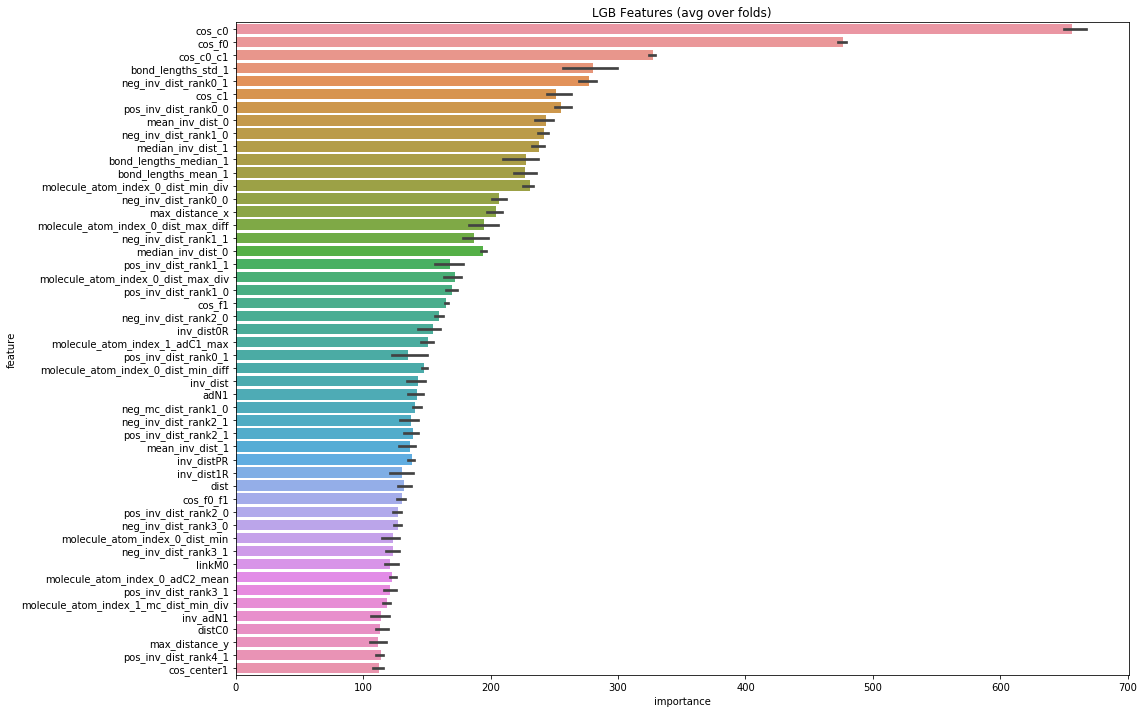

In [138]:
result_dict_lgb = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=1500)

In [139]:
result_dict_lgb["feature_importance"].groupby("feature").mean().sort_values("importance", ascending=False).head()

importance  fold
feature                                        
cos_c0                656.000000000000000     2
cos_f0                476.666666666666686     2
cos_c0_c1             327.555555555555486     2
bond_lengths_std_1    280.444444444444400     2
neg_inv_dist_rank0_1  277.000000000000000     2

In [140]:
# result_dict_lgb["feature_importance"].groupby("feature").mean().reset_index().sort_values("importance", ascending=False).head(80).columns

In [141]:
good_columns = result_dict_lgb["feature_importance"].groupby("feature").mean().reset_index().sort_values("importance", ascending=False).head(200)["feature"].values
good_columns = list(good_columns)

In [142]:
type(good_columns)

list

In [143]:
result_dict_lgb["feature_importance"].groupby("feature").mean().sort_values("importance", ascending=False).to_csv("result_dict_lgb.csv")

In [144]:
good_columns.append("type")
print(len(good_columns))
good_columns = set(good_columns)
print(len(good_columns))

201
201


In [145]:
good_columns = list(good_columns)

In [146]:
X = X[good_columns].copy()
X_test = X_test[good_columns].copy()

## Create out of fold feature

In [147]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [148]:
params1 = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

params2 = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 15,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

params3 = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 15,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

In [149]:
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y_fc.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
result_dict_lgb_oof =  {}
pattern1 = [0, 3, 1, 4, 7]
pattern2 = [5]
pattern3 = [2, 6]

for t in X['type'].unique():
    if t in pattern1:
        params = params1
    if t in pattern2:
        params = params2
    if t in pattern3:
        params = params3
    
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']
    result_dict_lgb_oof = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=300, n_estimators=n_estimators_default)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb_oof['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb_oof['prediction']

Training of type 0
Fold 1 started at Thu Jul 25 16:47:40 2019
Training until validation scores don't improve for 300 rounds.
[500]	training's l1: 0.67183	valid_1's l1: 0.869833
[1000]	training's l1: 0.500146	valid_1's l1: 0.789114
[1500]	training's l1: 0.399124	valid_1's l1: 0.752495
[2000]	training's l1: 0.328848	valid_1's l1: 0.731107
[2500]	training's l1: 0.275967	valid_1's l1: 0.717365
[3000]	training's l1: 0.235211	valid_1's l1: 0.707661
[3500]	training's l1: 0.201765	valid_1's l1: 0.700571
[4000]	training's l1: 0.174598	valid_1's l1: 0.695359
[4500]	training's l1: 0.15249	valid_1's l1: 0.691549
[5000]	training's l1: 0.133368	valid_1's l1: 0.688609
[5500]	training's l1: 0.116931	valid_1's l1: 0.686134
[6000]	training's l1: 0.102896	valid_1's l1: 0.684189
Did not meet early stopping. Best iteration is:
[6000]	training's l1: 0.102896	valid_1's l1: 0.684189
Fold 2 started at Thu Jul 25 16:58:09 2019
Training until validation scores don't improve for 300 rounds.
[500]	training's l1: 0

[3500]	training's l1: 0.023687	valid_1's l1: 0.166481
[4000]	training's l1: 0.0190527	valid_1's l1: 0.165925
[4500]	training's l1: 0.0154501	valid_1's l1: 0.165574
[5000]	training's l1: 0.012603	valid_1's l1: 0.165323
[5500]	training's l1: 0.0103765	valid_1's l1: 0.16512
[6000]	training's l1: 0.00861709	valid_1's l1: 0.164982
Did not meet early stopping. Best iteration is:
[6000]	training's l1: 0.00861709	valid_1's l1: 0.164982
CV mean score: -1.8075, std: 0.0081.
Training of type 1
Fold 1 started at Thu Jul 25 18:11:41 2019
Training until validation scores don't improve for 300 rounds.
[500]	training's l1: 0.142014	valid_1's l1: 0.37623
[1000]	training's l1: 0.061196	valid_1's l1: 0.362312
[1500]	training's l1: 0.0284047	valid_1's l1: 0.358636
[2000]	training's l1: 0.0126158	valid_1's l1: 0.357443
[2500]	training's l1: 0.00554549	valid_1's l1: 0.357031
[3000]	training's l1: 0.00296899	valid_1's l1: 0.356872
[3500]	training's l1: 0.0020736	valid_1's l1: 0.356832
[4000]	training's l1: 0

[2500]	training's l1: 0.00906918	valid_1's l1: 0.192535
[3000]	training's l1: 0.00573072	valid_1's l1: 0.192279
[3500]	training's l1: 0.00391056	valid_1's l1: 0.192156
[4000]	training's l1: 0.00283738	valid_1's l1: 0.192092
[4500]	training's l1: 0.00218304	valid_1's l1: 0.192057
[5000]	training's l1: 0.00176559	valid_1's l1: 0.192033
[5500]	training's l1: 0.00149184	valid_1's l1: 0.192017
[6000]	training's l1: 0.00131769	valid_1's l1: 0.192005
Did not meet early stopping. Best iteration is:
[6000]	training's l1: 0.00131769	valid_1's l1: 0.192005
CV mean score: -1.6501, std: 0.0075.
Training of type 2
Fold 1 started at Thu Jul 25 18:35:12 2019
Training until validation scores don't improve for 300 rounds.
[500]	training's l1: 0.257438	valid_1's l1: 0.369497
[1000]	training's l1: 0.179994	valid_1's l1: 0.341431
[1500]	training's l1: 0.135726	valid_1's l1: 0.329161
[2000]	training's l1: 0.106183	valid_1's l1: 0.322843
[2500]	training's l1: 0.0849627	valid_1's l1: 0.318905
[3000]	training'

[5500]	training's l1: 0.00429901	valid_1's l1: 0.167059
[6000]	training's l1: 0.00350746	valid_1's l1: 0.167013
Did not meet early stopping. Best iteration is:
[6000]	training's l1: 0.00350746	valid_1's l1: 0.167013
Fold 5 started at Thu Jul 25 20:47:42 2019
Training until validation scores don't improve for 300 rounds.
[500]	training's l1: 0.103266	valid_1's l1: 0.185814
[1000]	training's l1: 0.062979	valid_1's l1: 0.175037
[1500]	training's l1: 0.0420087	valid_1's l1: 0.171153
[2000]	training's l1: 0.0293946	valid_1's l1: 0.169425
[2500]	training's l1: 0.0210957	valid_1's l1: 0.168486
[3000]	training's l1: 0.015474	valid_1's l1: 0.167938
[3500]	training's l1: 0.0115662	valid_1's l1: 0.167612
[4000]	training's l1: 0.00880916	valid_1's l1: 0.167391
[4500]	training's l1: 0.00683053	valid_1's l1: 0.167254
[5000]	training's l1: 0.0053845	valid_1's l1: 0.167158
[5500]	training's l1: 0.00432718	valid_1's l1: 0.167096
[6000]	training's l1: 0.00353252	valid_1's l1: 0.167047
Did not meet early

[500]	training's l1: 0.0734388	valid_1's l1: 0.146354
[1000]	training's l1: 0.0408434	valid_1's l1: 0.13852
[1500]	training's l1: 0.0244533	valid_1's l1: 0.135701
[2000]	training's l1: 0.0151859	valid_1's l1: 0.134491
[2500]	training's l1: 0.00985083	valid_1's l1: 0.13398
[3000]	training's l1: 0.00670343	valid_1's l1: 0.133695
[3500]	training's l1: 0.004768	valid_1's l1: 0.133496
[4000]	training's l1: 0.00354326	valid_1's l1: 0.133398
[4500]	training's l1: 0.00274648	valid_1's l1: 0.133339
[5000]	training's l1: 0.00220534	valid_1's l1: 0.133301
[5500]	training's l1: 0.0018235	valid_1's l1: 0.13327
[6000]	training's l1: 0.0015523	valid_1's l1: 0.133254
Did not meet early stopping. Best iteration is:
[6000]	training's l1: 0.0015523	valid_1's l1: 0.133254
Fold 5 started at Thu Jul 25 22:30:55 2019
Training until validation scores don't improve for 300 rounds.
[500]	training's l1: 0.0725732	valid_1's l1: 0.14517
[1000]	training's l1: 0.0398765	valid_1's l1: 0.137382
[1500]	training's l1: 0

In [150]:
X['oof_fc'] = X_short['oof']
X_test['oof_fc'] = X_short_test['prediction']

<a id="id6"></a> <br> 
# 5. Final Model

## Training models for each type

In [151]:
params1 = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

params2 = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 15,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

params3 = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

In [152]:
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
pattern1 = [0, 3, 1, 7]
pattern2 = [2, 6, 5]
pattern3 = [4]

for t in X['type'].unique():
    if t in pattern1:
        params = params1
    if t in pattern2:
        params = params2
    if t in pattern3:
        params = params3
    
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']
    result_dict_lgb3 = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=600, n_estimators=n_estimators_default)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb3['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb3['prediction']

Training of type 0
Fold 1 started at Thu Jul 25 22:35:07 2019
Training until validation scores don't improve for 600 rounds.
[500]	training's l1: 0.516713	valid_1's l1: 0.672721
[1000]	training's l1: 0.394528	valid_1's l1: 0.655465
[1500]	training's l1: 0.304622	valid_1's l1: 0.642315
[2000]	training's l1: 0.239717	valid_1's l1: 0.632319
[2500]	training's l1: 0.192408	valid_1's l1: 0.62447
[3000]	training's l1: 0.156117	valid_1's l1: 0.618813
[3500]	training's l1: 0.128361	valid_1's l1: 0.614368
[4000]	training's l1: 0.10653	valid_1's l1: 0.611127
[4500]	training's l1: 0.0887767	valid_1's l1: 0.608715
[5000]	training's l1: 0.074315	valid_1's l1: 0.606646
[5500]	training's l1: 0.0624998	valid_1's l1: 0.605154
[6000]	training's l1: 0.05259	valid_1's l1: 0.603825
Did not meet early stopping. Best iteration is:
[6000]	training's l1: 0.05259	valid_1's l1: 0.603825
[1000]	training's l1: 0.388738	valid_1's l1: 0.652913
[1500]	training's l1: 0.302194	valid_1's l1: 0.640055
[2000]	training's l1

[4500]	training's l1: 0.00650003	valid_1's l1: 0.138216
[5000]	training's l1: 0.00490119	valid_1's l1: 0.138051
[5500]	training's l1: 0.00380158	valid_1's l1: 0.137941
[6000]	training's l1: 0.00301649	valid_1's l1: 0.137866
Did not meet early stopping. Best iteration is:
[6000]	training's l1: 0.00301649	valid_1's l1: 0.137866
CV mean score: -1.9901, std: 0.0068.
Training of type 1
Fold 1 started at Fri Jul 26 00:28:58 2019
Training until validation scores don't improve for 600 rounds.
[500]	training's l1: 0.153478	valid_1's l1: 0.351985
[1000]	training's l1: 0.0675678	valid_1's l1: 0.343244
[1500]	training's l1: 0.0309621	valid_1's l1: 0.339741
[2000]	training's l1: 0.0139538	valid_1's l1: 0.338478
[2500]	training's l1: 0.00621528	valid_1's l1: 0.337865
[3000]	training's l1: 0.00318688	valid_1's l1: 0.33769
[3500]	training's l1: 0.00216937	valid_1's l1: 0.337638
[4000]	training's l1: 0.00173085	valid_1's l1: 0.337608
[4500]	training's l1: 0.00149178	valid_1's l1: 0.337592
[5000]	traini

Fold 5 started at Fri Jul 26 00:49:11 2019
Training until validation scores don't improve for 600 rounds.
[500]	training's l1: 0.07785	valid_1's l1: 0.172935
[1000]	training's l1: 0.0387881	valid_1's l1: 0.166023
[1500]	training's l1: 0.0210232	valid_1's l1: 0.16351
[2000]	training's l1: 0.0120199	valid_1's l1: 0.162382
[2500]	training's l1: 0.00727872	valid_1's l1: 0.161934
[3000]	training's l1: 0.00474789	valid_1's l1: 0.161709
[3500]	training's l1: 0.00332121	valid_1's l1: 0.161598
[4000]	training's l1: 0.00248209	valid_1's l1: 0.161534
[4500]	training's l1: 0.00195283	valid_1's l1: 0.161491
[5000]	training's l1: 0.00161455	valid_1's l1: 0.161466
[5500]	training's l1: 0.00139506	valid_1's l1: 0.161452
[6000]	training's l1: 0.00124694	valid_1's l1: 0.161439
Did not meet early stopping. Best iteration is:
[6000]	training's l1: 0.00124694	valid_1's l1: 0.161439
CV mean score: -1.8302, std: 0.0094.
Training of type 2
Fold 1 started at Fri Jul 26 00:52:27 2019
Training until validation s

[2500]	training's l1: 0.0183529	valid_1's l1: 0.151589
[3000]	training's l1: 0.013479	valid_1's l1: 0.151089
[3500]	training's l1: 0.0101149	valid_1's l1: 0.150787
[4000]	training's l1: 0.00773314	valid_1's l1: 0.150585
[4500]	training's l1: 0.0060327	valid_1's l1: 0.150451
[5000]	training's l1: 0.00480296	valid_1's l1: 0.150359
[5500]	training's l1: 0.00389375	valid_1's l1: 0.150293
[6000]	training's l1: 0.00320792	valid_1's l1: 0.150239
Did not meet early stopping. Best iteration is:
[6000]	training's l1: 0.00320792	valid_1's l1: 0.150239
Fold 5 started at Fri Jul 26 03:08:26 2019
Training until validation scores don't improve for 600 rounds.
[500]	training's l1: 0.0882955	valid_1's l1: 0.160158
[1000]	training's l1: 0.0550428	valid_1's l1: 0.155533
[1500]	training's l1: 0.0368089	valid_1's l1: 0.153096
[2000]	training's l1: 0.0256243	valid_1's l1: 0.151731
[2500]	training's l1: 0.0184436	valid_1's l1: 0.150929
[3000]	training's l1: 0.0135397	valid_1's l1: 0.150446
[3500]	training's 

[5500]	training's l1: 0.00111782	valid_1's l1: 0.117647
[6000]	training's l1: 0.00102924	valid_1's l1: 0.11764
Did not meet early stopping. Best iteration is:
[6000]	training's l1: 0.00102924	valid_1's l1: 0.11764
Fold 4 started at Fri Jul 26 05:19:52 2019
Training until validation scores don't improve for 600 rounds.
[500]	training's l1: 0.0607518	valid_1's l1: 0.126162
[1000]	training's l1: 0.0313057	valid_1's l1: 0.122293
[1500]	training's l1: 0.0166053	valid_1's l1: 0.120306
[2000]	training's l1: 0.00903483	valid_1's l1: 0.119499
[2500]	training's l1: 0.00509993	valid_1's l1: 0.119121
[3000]	training's l1: 0.00315538	valid_1's l1: 0.118939
[3500]	training's l1: 0.00219626	valid_1's l1: 0.118858
[4000]	training's l1: 0.0017049	valid_1's l1: 0.118815
[4500]	training's l1: 0.00142088	valid_1's l1: 0.118795
[5000]	training's l1: 0.00124351	valid_1's l1: 0.118777
[5500]	training's l1: 0.00112229	valid_1's l1: 0.118767
[6000]	training's l1: 0.00103303	valid_1's l1: 0.118759
Did not meet 

```
Local CV
type 0(1JHC): CV mean score: -0.5072, std: 0.0029.
type 1(1JHN): CV mean score: -1.0749, std: 0.0067.
type 2(2JHC): CV mean score: -1.3487, std: 0.0022.
type 3(2JHH): CV mean score: -1.9901, std: 0.0068.
type 4(2JHN): CV mean score: -1.8302, std: 0.0094.
type 5(3JHC): CV mean score: -1.3479, std: 0.0023.
type 6(3JHH): CV mean score: -1.8943, std: 0.0069.
type 7(3JHN): CV mean score: -2.1367, std: 0.0043.
```

- 1JHC, 1JHN, 2JHC, 3JHC CV is row

<a id="id7"></a> <br> 
# 6. Submittion

In [153]:
sub = pd.read_csv(CSV_SUBMISSION)

In [154]:
#Training models for type
sub['scalar_coupling_constant'] = X_short_test['prediction']
sub.to_csv('submission_type.csv', index=False)
sub.head()

id  scalar_coupling_constant
0  4658147        15.423782512388158
1  4658148       192.180151827951761
2  4658149         9.510699887838101
3  4658150       189.014555497325006
4  4658151         6.910646011489760